# NanoMAD ML: CNN-Based MAD Fitting for BCDI Analysis

## A Comprehensive Demonstration of Phase 6.0

---

This notebook provides a complete walkthrough of the NanoMAD ML system, which uses a Convolutional Neural Network (CNN) to replace traditional iterative Multi-wavelength Anomalous Diffraction (MAD) fitting in Bragg Coherent Diffraction Imaging (BCDI) analysis of core-shell nanoparticles.

### Table of Contents

1. [Introduction & Physics Background](#1.-Introduction-&-Physics-Background)
2. [Particle Generation & Visualization](#2.-Particle-Generation-&-Visualization)
3. [Displacement Fields & Phase](#3.-Displacement-Fields-&-Phase)
4. [Multi-Energy Diffraction Computation](#4.-Multi-Energy-Diffraction-Computation)
5. [Ground Truth Labels](#5.-Ground-Truth-Labels)
6. [Loss Function Design](#6.-Loss-Function-Design)
7. [CNN Architecture](#7.-CNN-Architecture)
8. [Training Pipeline](#8.-Training-Pipeline)
9. [Inference & Results](#9.-Inference-&-Results)
10. [Evaluation Data: 3D Test Dataset Analysis](#Evaluation-Data:-3D-Test-Dataset-Analysis)
11. [Summary & Future Work](#10.-Summary-&-Future-Work)

---

**Note**: This notebook runs without PyTorch! It uses only numpy/matplotlib to demonstrate the physics and data flow. PyTorch is only needed for actual training and inference.

---

## Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path('.').resolve().parent))

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


In [2]:
from src.core_shell import (
    create_particle_with_shape,
    apply_displacement_to_particle,
    create_layered_displacement_field,
    compute_diffraction_oversampled_cropped,
    ScatteringFactors,
    compute_ground_truth_labels,
    DEFAULT_PIXEL_SIZE,
)

print("Core modules imported successfully!")

Core modules imported successfully!


---

# 1. Introduction & Physics Background

## The Scientific Problem

We study **core-shell nanoparticles** (e.g., Fe core with Ni shell) using **Bragg Coherent Diffraction Imaging (BCDI)**. The goal is to separate the contributions of the core and shell materials to understand their individual structures.

## Multi-wavelength Anomalous Diffraction (MAD)

By measuring diffraction at multiple X-ray energies near an absorption edge (e.g., Ni K-edge at ~8333 eV), we can exploit the energy-dependent scattering of the anomalous element to separate contributions.

### The MAD Equation

$$I(\mathbf{Q}, E) = |F_T|^2 + (f'^2 + f''^2)\frac{|F_A|^2}{f_0^2} + 2\frac{|F_T||F_A|}{f_0}\left[f'\cos(\Delta\phi) + f''\sin(\Delta\phi)\right]$$

Where:
- $|F_T|$ = Total structure factor magnitude (all atoms, Thomson-weighted)
- $|F_A|$ = Anomalous structure factor magnitude (only Ni atoms)
- $\Delta\phi = \phi_T - \phi_A$ = Phase difference between total and anomalous
- $f'(E), f''(E)$ = Anomalous scattering corrections (energy-dependent)
- $f_0(Q)$ = Thomson scattering factor

### The Inverse Problem

**Traditional approach (NanoMAD):** Iteratively fit $(|F_T|, |F_A|, \Delta\phi)$ at each pixel to match observed intensities across energies. This is slow (~hours for a 3D dataset).

**Our approach (NanoMAD ML):** Train a CNN to directly predict $(|F_T|, |F_A|, \sin\Delta\phi, \cos\Delta\phi)$ from intensity patches. This is fast (~seconds for inference).

### Anomalous Scattering Factors

Let's visualize how $f'$ and $f''$ vary with energy near the Ni K-edge:

In [ ]:
# Load scattering factors
sf = ScatteringFactors()  # Auto-detect data directory

# Energy range around Ni K-edge
energies = np.linspace(8250, 8400, 200)
f_prime = [sf.get_f_prime('Ni', E) for E in energies]
f_double_prime = [sf.get_f_double_prime('Ni', E) for E in energies]

# Our 8 measurement energies
ENERGIES = [8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348]
fp_measured = [sf.get_f_prime('Ni', E) for E in ENERGIES]
fs_measured = [sf.get_f_double_prime('Ni', E) for E in ENERGIES]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(energies, f_prime, 'b-', linewidth=2, label="f' (real)")
ax1.plot(energies, f_double_prime, 'r-', linewidth=2, label="f'' (imaginary)")
ax1.scatter(ENERGIES, fp_measured, c='blue', s=100, zorder=5, edgecolors='white', linewidth=2)
ax1.scatter(ENERGIES, fs_measured, c='red', s=100, zorder=5, edgecolors='white', linewidth=2)
ax1.axvline(8333, color='gray', linestyle='--', alpha=0.5, label='Ni K-edge')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Scattering factor (electrons)')
ax1.set_title('Ni Anomalous Scattering Factors')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.scatter(fp_measured, fs_measured, c=ENERGIES, cmap='viridis', s=150, edgecolors='black', linewidth=1.5)
for i, E in enumerate(ENERGIES):
    ax2.annotate(f'{E} eV', (fp_measured[i], fs_measured[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel("f' (electrons)")
ax2.set_ylabel("f'' (electrons)")
ax2.set_title('f\' vs f"  at Measurement Energies')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Measurement energies: {ENERGIES} eV")
print(f"f' range: [{min(fp_measured):.2f}, {max(fp_measured):.2f}] electrons")
print(f"f'' range: [{min(fs_measured):.2f}, {max(fs_measured):.2f}] electrons")

---

# 2. Particle Generation & Visualization

We generate synthetic core-shell particles with various shapes and composition profiles for training data.

## Particle Representation

Each particle is represented on a 2D grid where each pixel contains:
- **Composition** $x_{Ni}$: Nickel fraction (0 = pure Fe, 1 = pure Ni)
- **Amplitude**: Whether the pixel is inside (1) or outside (0) the particle

## Shape Variety

Training data includes 5 shape types to ensure the CNN generalizes well:

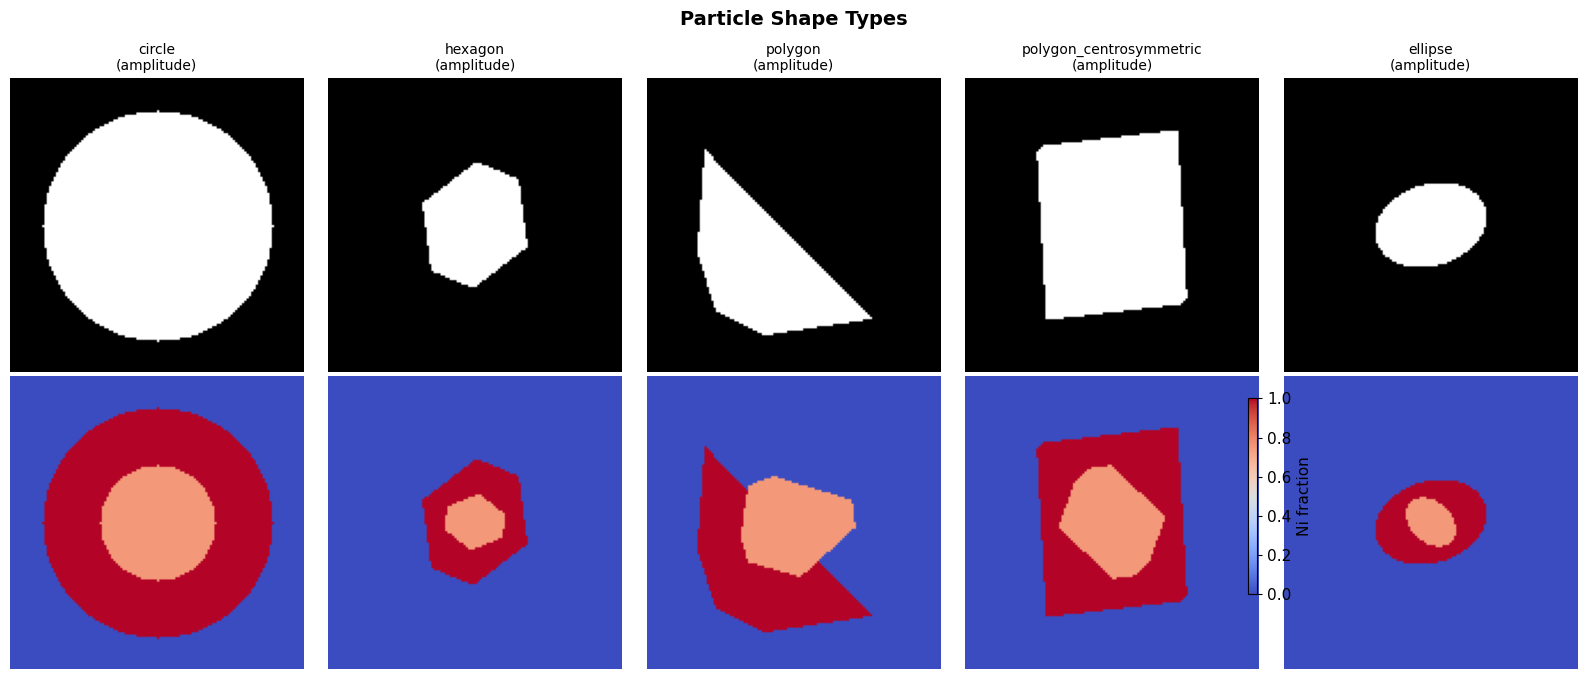

In [4]:
# Generate examples of each shape type
np.random.seed(42)
GRID_SIZE = 128

# Define compositions: core is Fe-rich (Ni3Fe = 25% Fe), shell is pure Ni
core_comp = {'Ni': 0.75, 'Fe': 0.25}  # Ni3Fe
shell_comp = {'Ni': 1.0, 'Fe': 0.0}   # Pure Ni

shapes = ['circle', 'hexagon', 'polygon', 'polygon_centrosymmetric', 'ellipse']
shape_params_list = [{}, {'anisotropy': 1.2}, {'n_vertices': 7}, {'n_vertices': 5}, {'aspect_ratio': 1.4}]

fig, axes = plt.subplots(2, 5, figsize=(16, 7))

for col in range(5):
    shape_type = shapes[col]
    shape_params = shape_params_list[col]
    
    particle_data, metadata = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type=shape_type,
        composition_mode='sharp',
        core_fraction=0.5,
        core_composition=core_comp,
        shell_composition=shell_comp,
        shape_params=shape_params,
        verbose=False
    )
    
    # Extract amplitude (outer mask) and composition (Ni fraction)
    amplitude = metadata['outer_mask'].astype(float)
    total = particle_data[0] + particle_data[1]
    composition = np.where(total > 0, particle_data[0] / total, 0)
    
    # Plot amplitude (particle shape)
    axes.flat[col].imshow(amplitude, cmap='gray')
    axes.flat[col].set_title(f'{shape_type}\n(amplitude)', fontsize=10)
    axes.flat[col].axis('off')
    
    # Plot composition (bottom row = col + 5)
    im2 = axes.flat[col + 5].imshow(composition, cmap='coolwarm', vmin=0, vmax=1)
    axes.flat[col + 5].set_title('composition (Ni fraction)', fontsize=10)
    axes.flat[col + 5].axis('off')

plt.colorbar(im2, ax=list(axes.flat[5:10]), shrink=0.8, label='Ni fraction')
plt.suptitle('Particle Shape Types', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Composition Modes

Beyond the traditional sharp core-shell boundary, we include various composition profiles:

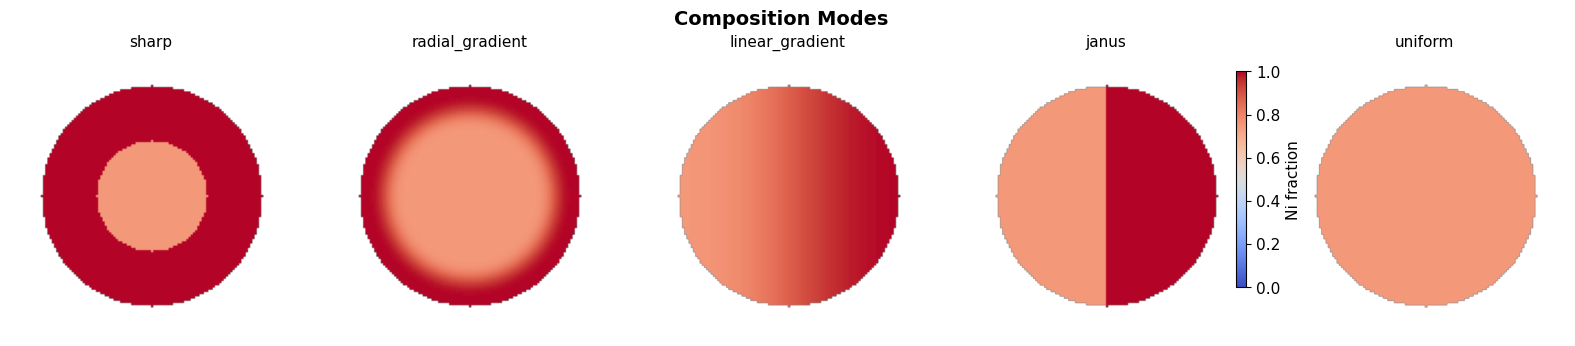

Composition mode distribution in training data:
  sharp: 40%  |  radial_gradient: 18%  |  linear_gradient: 10%
  janus: 8%   |  multi_shell: 7%       |  uniform: 17%


In [5]:
composition_modes = [
    ('sharp', {}),
    ('radial_gradient', {}),
    ('linear_gradient', {'gradient_angle': 45}),
    ('janus', {'split_angle': 0}),
    ('uniform', {}),
]

fig, axes = plt.subplots(1, 5, figsize=(16, 3.5))

for idx, (mode, comp_params) in enumerate(composition_modes):
    particle_data, metadata = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='circle',
        composition_mode=mode,
        core_fraction=0.5,
        core_composition=core_comp,
        shell_composition=shell_comp,
        composition_params=comp_params,
        verbose=False
    )
    
    # Extract amplitude and composition
    amplitude = metadata['outer_mask'].astype(float)
    total = particle_data[0] + particle_data[1]
    composition = np.where(total > 0, particle_data[0] / total, 0)
    
    # Mask outside particle
    comp_masked = np.ma.masked_where(amplitude < 0.5, composition)
    
    im = axes[idx].imshow(comp_masked, cmap='coolwarm', vmin=0, vmax=1)
    axes[idx].set_title(f'{mode}', fontsize=11)
    axes[idx].axis('off')

plt.colorbar(im, ax=axes, shrink=0.8, label='Ni fraction', orientation='vertical')
plt.suptitle('Composition Modes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Composition mode distribution in training data:")
print("  sharp: 40%  |  radial_gradient: 18%  |  linear_gradient: 10%")
print("  janus: 8%   |  multi_shell: 7%       |  uniform: 17%")

---

# 3. Displacement Fields & Phase

Real nanoparticles have **lattice strain** due to the mismatch between core and shell lattice parameters. This strain creates a spatially-varying displacement field that affects the diffraction pattern.

## Physical Origin

- Fe and Ni have different lattice constants
- At the core-shell interface, the lattice must accommodate this mismatch
- This creates strain that decays away from the interface

## Our Model

We use a **layered displacement field** that depends on the local composition gradient:


  Creating layered displacement field (shape-aware)...
    Grid size: 128×128
    Pixel size: 10.0 Å

    Layer 1: Interface strain (core-shell mismatch)
      Lattice mismatch: 0.60%
    Signed distance field computed:
      Inside range: [-103.0, -10.0] (negative)
      Outside range: [10.0, 785.2] (positive)
      Interface displacement range: [-0.309, 0.421] Å

    Layer 2: Surface relaxation
      Amplitude: 0.20 Å
    Surface relaxation field computed:
      Relaxation depth: 50.0 Å
      Field range (inside): [0.018, 1.000]

    Corner enhancement (multiplicative)
      Enhancement amplitude: 0.30
      No corner positions provided - skipping corner enhancement

    Combined displacement field:
      Total range: [-0.305, 0.621] Å
      RMS displacement: 0.226 Å


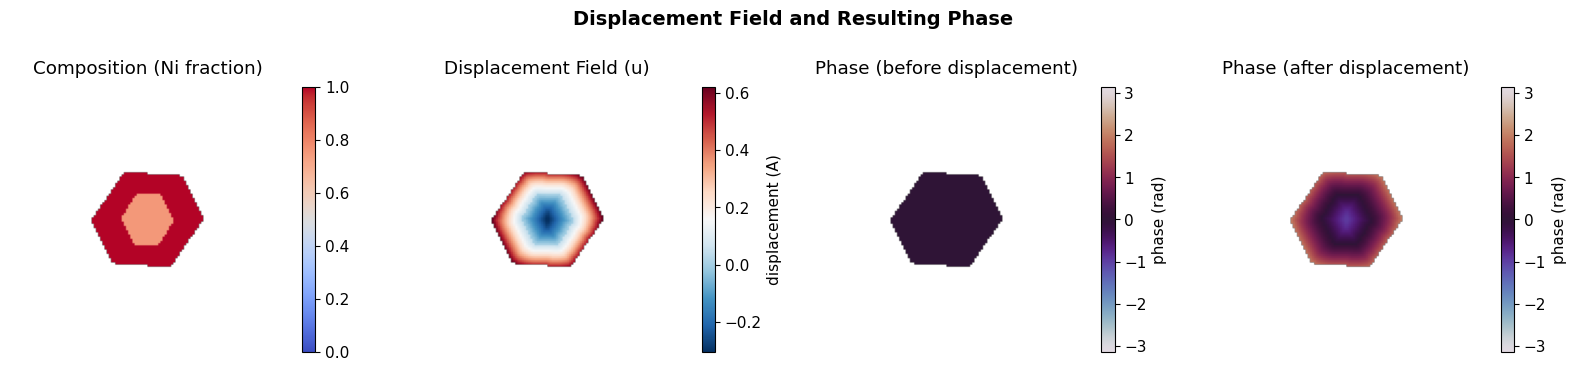

Phase = Q_Bragg x displacement
Q_Bragg = 3.1 A^-1
Displacement range: [-0.305, 0.621] A


In [6]:
# Create a particle with displacement
particle_data, metadata = create_particle_with_shape(
    grid_size=GRID_SIZE,
    shape_type='hexagon',
    composition_mode='sharp',
    core_fraction=0.5,
    core_composition=core_comp,
    shell_composition=shell_comp,
    shape_params={'anisotropy': 1.1},
    verbose=False
)

# Extract amplitude and composition from the return values
amplitude = metadata['outer_mask'].astype(float)
total = particle_data[0] + particle_data[1]
composition = np.where(total > 0, particle_data[0] / total, 0)

# Create displacement field using masks from metadata
displacement, disp_info = create_layered_displacement_field(
    core_mask=metadata['core_mask'],
    outer_mask=metadata['outer_mask'],
    pixel_size=DEFAULT_PIXEL_SIZE,
)

# Apply displacement to particle
Q_BRAGG = 3.1  # A^-1
particle_displaced = apply_displacement_to_particle(particle_data, displacement, Q_BRAGG)

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Composition
comp_masked = np.ma.masked_where(amplitude < 0.5, composition)
im0 = axes[0].imshow(comp_masked, cmap='coolwarm', vmin=0, vmax=1)
axes[0].set_title('Composition (Ni fraction)')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Displacement field
disp_masked = np.ma.masked_where(amplitude < 0.5, displacement)
im1 = axes[1].imshow(disp_masked, cmap='RdBu_r')
axes[1].set_title('Displacement Field (u)')
plt.colorbar(im1, ax=axes[1], shrink=0.8, label='displacement (A)')

# Phase before displacement (zero everywhere)
phase_before = np.ma.masked_where(amplitude < 0.5, np.zeros_like(amplitude))
im2 = axes[2].imshow(phase_before, cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[2].set_title('Phase (before displacement)')
plt.colorbar(im2, ax=axes[2], shrink=0.8, label='phase (rad)')

# Phase after displacement
phase_from_disp = Q_BRAGG * displacement
phase_after = np.ma.masked_where(amplitude < 0.5, phase_from_disp)
im3 = axes[3].imshow(phase_after, cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[3].set_title('Phase (after displacement)')
plt.colorbar(im3, ax=axes[3], shrink=0.8, label='phase (rad)')

for ax in axes:
    ax.axis('off')

plt.suptitle('Displacement Field and Resulting Phase', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Phase = Q_Bragg x displacement")
print(f"Q_Bragg = {Q_BRAGG} A^-1")
disp_inside = displacement[metadata['outer_mask']]
print(f"Displacement range: [{disp_inside.min():.3f}, {disp_inside.max():.3f}] A")

---

# 4. Multi-Energy Diffraction Computation

Now we compute diffraction patterns at 8 energies around the Ni K-edge.

## The Diffraction Calculation

For each energy $E$, the complex scattering amplitude is:

$$\rho(\mathbf{r}, E) = A(\mathbf{r}) \cdot e^{i\phi(\mathbf{r})} \cdot \left[ x_{Ni}(\mathbf{r}) \cdot f_{Ni}(E) + (1 - x_{Ni}(\mathbf{r})) \cdot f_{Fe}(E) \right]$$

The diffraction pattern is:

$$I(\mathbf{Q}, E) = |\mathcal{F}\{\rho(\mathbf{r}, E)\}|^2$$

In [7]:
# Compute diffraction at all 8 energies
ENERGIES = [8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348]

diffraction_dict = compute_diffraction_oversampled_cropped(
    particle=particle_displaced,
    energies=ENERGIES,
    pixel_size=DEFAULT_PIXEL_SIZE,
    scattering_factors=sf,
    output_size=128,
    verbose=False
)

# Convert dict to intensity cube (height, width, n_energies)
intensity_cube = np.stack([np.abs(diffraction_dict[E])**2 for E in ENERGIES], axis=-1)

print(f"Intensity cube shape: {intensity_cube.shape}")
print(f"  (height, width, n_energies) = (128, 128, 8)")

Intensity cube shape: (128, 128, 8)
  (height, width, n_energies) = (128, 128, 8)


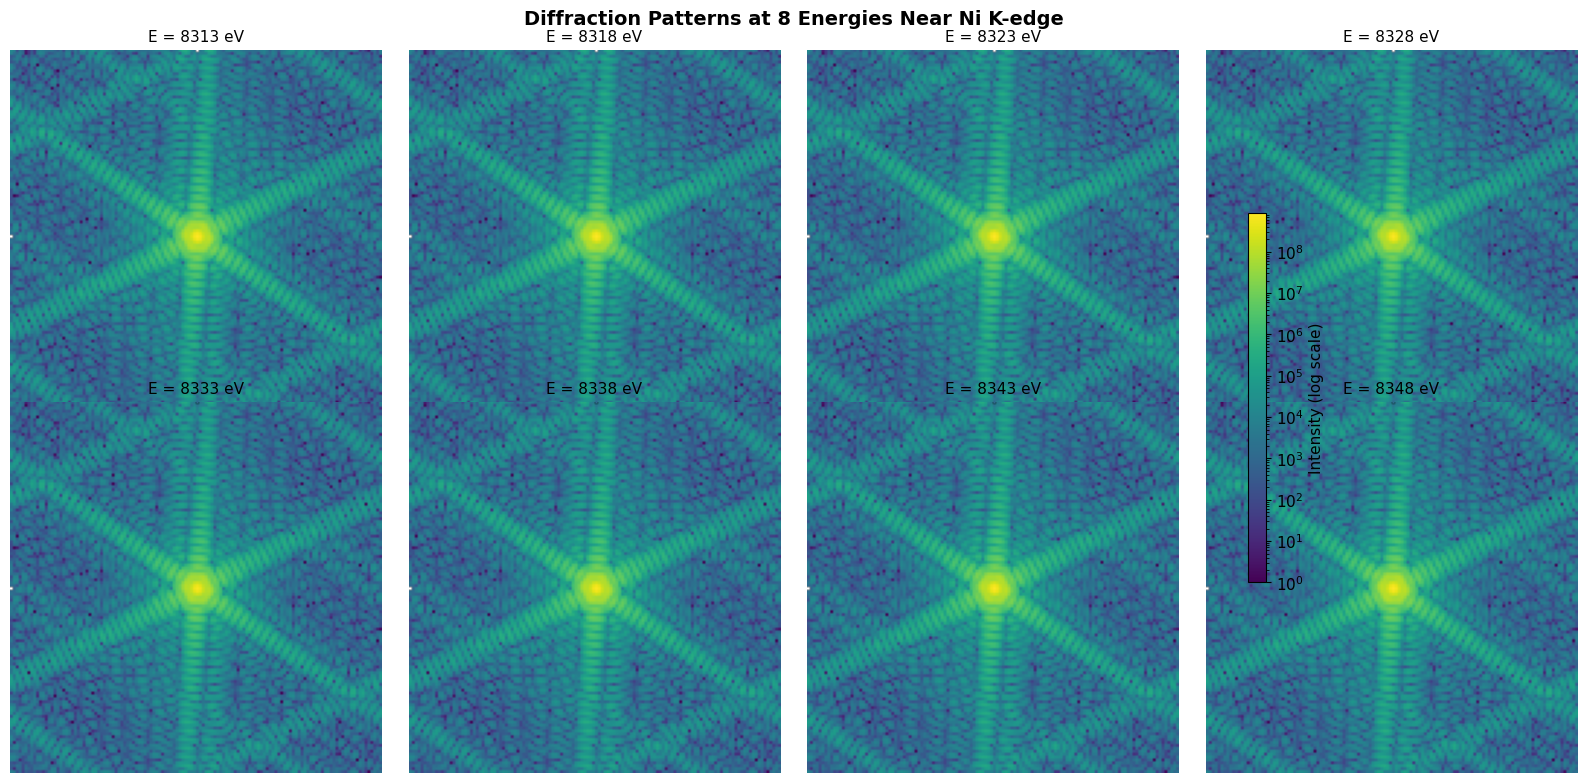

In [8]:
# Visualize diffraction patterns at different energies
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (ax, E) in enumerate(zip(axes.flat, ENERGIES)):
    im = ax.imshow(intensity_cube[:, :, i], norm=LogNorm(vmin=1, vmax=intensity_cube.max()), cmap='viridis')
    ax.set_title(f'E = {E} eV', fontsize=11)
    ax.axis('off')

plt.colorbar(im, ax=axes, shrink=0.6, label='Intensity (log scale)')
plt.suptitle('Diffraction Patterns at 8 Energies Near Ni K-edge', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

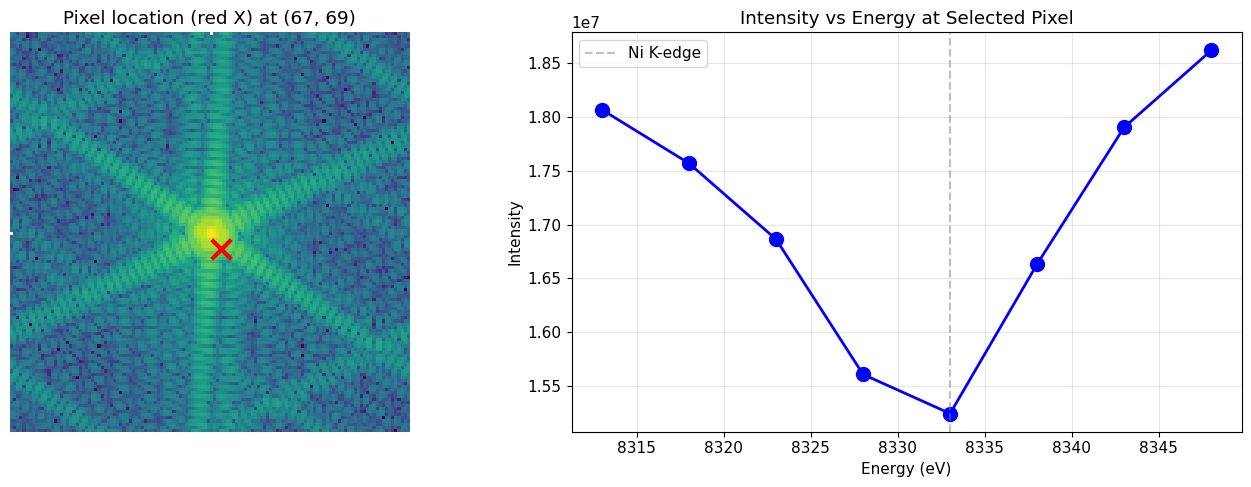

The intensity variation with energy encodes the MAD parameters.
The CNN learns to decode this I(E) curve into |F_T|, |F_A|, and Δφ.


In [9]:
# Show how intensity varies with energy at a specific pixel
# Pick a pixel with significant signal
cy, cx = 64, 64  # Center
pixel_y, pixel_x = cy + 5, cx + 3  # Slightly off-center

intensities_at_pixel = intensity_cube[pixel_y, pixel_x, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Show which pixel we're looking at
ax1.imshow(intensity_cube[:, :, 4], norm=LogNorm(vmin=1), cmap='viridis')
ax1.scatter([pixel_x], [pixel_y], c='red', s=200, marker='x', linewidths=3)
ax1.set_title(f'Pixel location (red X) at ({pixel_x}, {pixel_y})')
ax1.axis('off')

# Plot I(E) at that pixel
ax2.plot(ENERGIES, intensities_at_pixel, 'bo-', markersize=10, linewidth=2)
ax2.axvline(8333, color='gray', linestyle='--', alpha=0.5, label='Ni K-edge')
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Intensity')
ax2.set_title('Intensity vs Energy at Selected Pixel')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The intensity variation with energy encodes the MAD parameters.")
print("The CNN learns to decode this I(E) curve into |F_T|, |F_A|, and Δφ.")

---

# 5. Ground Truth Labels

For supervised training, we need ground truth labels. These are computed directly from the known particle structure.

## What the CNN Predicts

The CNN outputs 4 channels at each pixel:

| Channel | Quantity | Range | Physical Meaning |
|---------|----------|-------|------------------|
| 0 | $|F_T|$ | $[0, \infty)$ | Total structure factor magnitude |
| 1 | $|F_A|$ | $[0, \infty)$ | Anomalous (Ni) structure factor magnitude |
| 2 | $\sin(\Delta\phi)$ | $[-1, 1]$ | Sine of phase difference |
| 3 | $\cos(\Delta\phi)$ | $[-1, 1]$ | Cosine of phase difference |

### Why sin/cos instead of Δφ directly?

Phases have a discontinuity at ±π. By predicting sin and cos separately, we avoid this wraparound issue. The phase can be recovered as:

$$\Delta\phi = \text{atan2}(\sin\Delta\phi, \cos\Delta\phi)$$

In [10]:
# Compute ground truth labels
labels = compute_ground_truth_labels(
    particle=particle_displaced,
    pixel_size=DEFAULT_PIXEL_SIZE,
    output_size=128
)

print("Ground truth labels computed:")
for key, arr in labels.items():
    print(f"  {key}: shape={arr.shape}, range=[{arr.min():.3f}, {arr.max():.3f}]")


  Computing ground truth labels (Thomson-weighted)...
    f₀_Ni(Q=0) = 27.99 (atomic number ~28)
    f₀_Fe(Q=0) = 25.99 (atomic number ~26)
    Q_max = 0.31 Å⁻¹
    |F_T| range: [0.00e+00, 3.67e+04]
    |F_A| range: [0.00e+00, 3.53e+04]
    |F_A|/|F_T| at max: 96.06%
    Δφ range: [-3.113, 3.130] rad
    Δφ range: [-178.4°, 179.3°]
    |F_N| (direct) range: [0.00e+00, 2.69e+03]
    |F_N| (derived) range: [0.00e+00, 2.69e+03]
    |F_N| derivation error (max relative): 2.70e-15
Ground truth labels computed:
  F_T_mag: shape=(128, 128), range=[0.000, 36739.535]
  F_A_mag: shape=(128, 128), range=[0.000, 35290.851]
  delta_phi: shape=(128, 128), range=[-3.113, 3.130]
  cos_delta_phi: shape=(128, 128), range=[-1.000, 1.000]
  sin_delta_phi: shape=(128, 128), range=[-1.000, 1.000]
  F_N_mag: shape=(128, 128), range=[0.000, 2693.295]
  F_N_mag_derived: shape=(128, 128), range=[0.000, 2693.295]
  f0_Ni: shape=(128, 128), range=[27.667, 27.987]
  f0_Fe: shape=(128, 128), range=[25.640, 25.990]

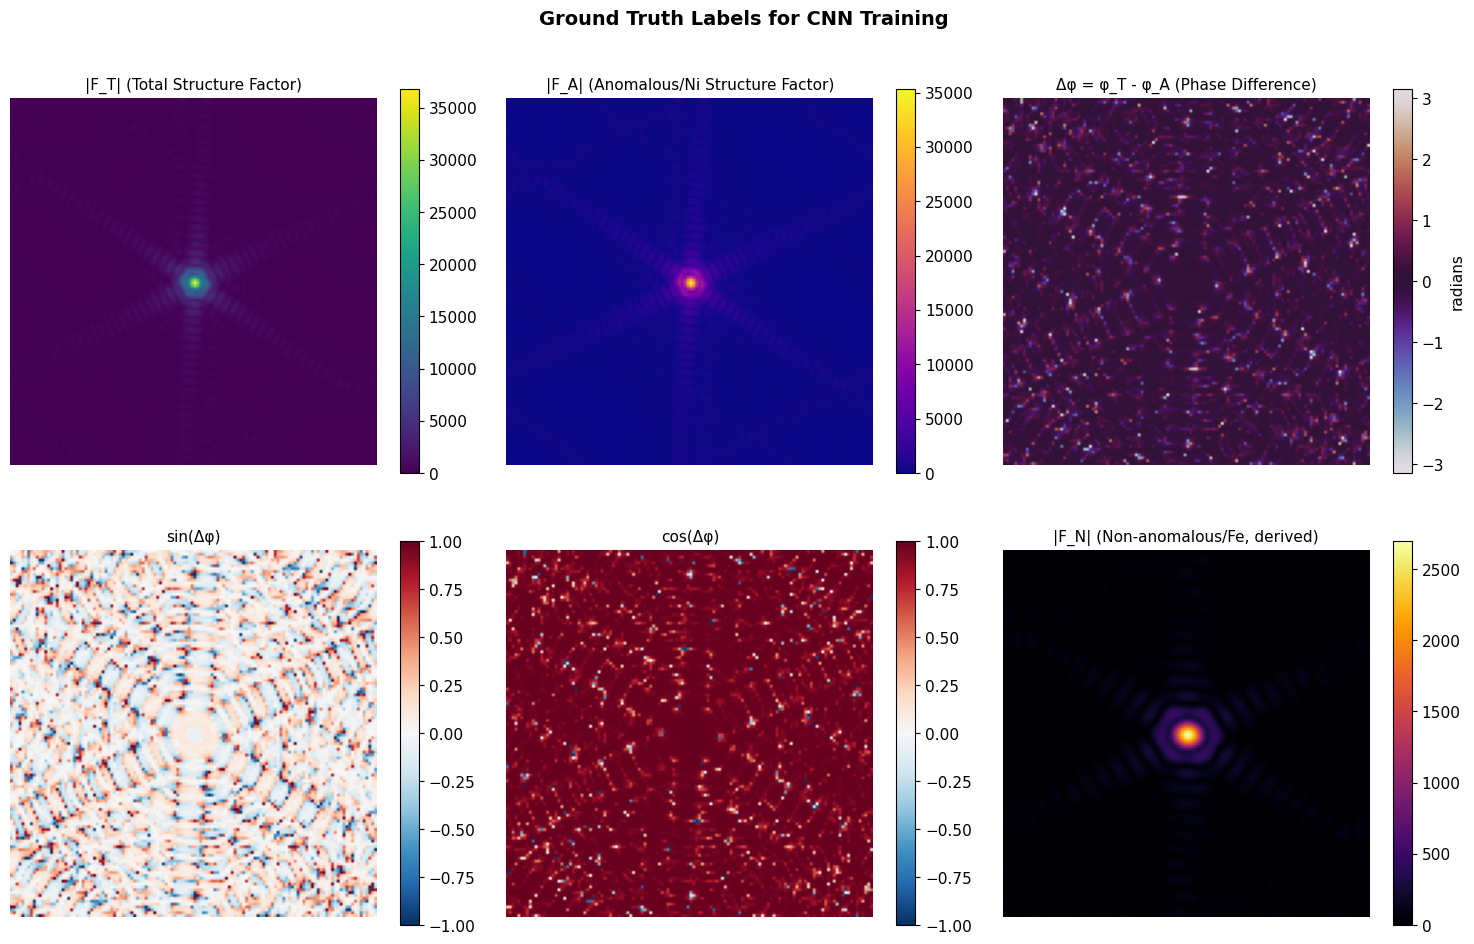

In [11]:
# Visualize ground truth labels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# F_T magnitude
im0 = axes[0, 0].imshow(labels['F_T_mag'], cmap='viridis')
axes[0, 0].set_title('|F_T| (Total Structure Factor)', fontsize=11)
plt.colorbar(im0, ax=axes[0, 0], shrink=0.8)

# F_A magnitude
im1 = axes[0, 1].imshow(labels['F_A_mag'], cmap='plasma')
axes[0, 1].set_title('|F_A| (Anomalous/Ni Structure Factor)', fontsize=11)
plt.colorbar(im1, ax=axes[0, 1], shrink=0.8)

# Delta phi
delta_phi = np.arctan2(labels['sin_delta_phi'], labels['cos_delta_phi'])
im2 = axes[0, 2].imshow(delta_phi, cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[0, 2].set_title('Δφ = φ_T - φ_A (Phase Difference)', fontsize=11)
plt.colorbar(im2, ax=axes[0, 2], shrink=0.8, label='radians')

# Sin and Cos
im3 = axes[1, 0].imshow(labels['sin_delta_phi'], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('sin(Δφ)', fontsize=11)
plt.colorbar(im3, ax=axes[1, 0], shrink=0.8)

im4 = axes[1, 1].imshow(labels['cos_delta_phi'], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_title('cos(Δφ)', fontsize=11)
plt.colorbar(im4, ax=axes[1, 1], shrink=0.8)

# F_N (derived quantity - Fe contribution)
F_N_sq = (labels['F_T_mag']**2 + labels['F_A_mag']**2 
          - 2 * labels['F_T_mag'] * labels['F_A_mag'] * labels['cos_delta_phi'])
F_N_mag = np.sqrt(np.maximum(F_N_sq, 0))
im5 = axes[1, 2].imshow(F_N_mag, cmap='inferno')
axes[1, 2].set_title('|F_N| (Non-anomalous/Fe, derived)', fontsize=11)
plt.colorbar(im5, ax=axes[1, 2], shrink=0.8)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle('Ground Truth Labels for CNN Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### The Derived Quantity: F_N

From the predicted quantities, we can compute $|F_N|$ (the non-anomalous/Fe structure factor) using the law of cosines:

$$|F_N|^2 = |F_T|^2 + |F_A|^2 - 2|F_T||F_A|\cos(\Delta\phi)$$

This isolates the Fe core contribution, which is the primary scientific goal!

---

# 6. Loss Function Design

The loss function is critical for training. We use a **physics-informed loss** with three components.

## Loss Components

### 1. Weighted MSE Loss

$$L_{MSE} = \sum_{x,y} w(x,y) \cdot ||\text{pred} - \text{target}||^2$$

where $w(x,y) \propto \sqrt{I_{total}(x,y)}$

**Why weight by intensity?**
- High-intensity pixels have better signal-to-noise ratio
- For Poisson statistics: $\sigma(I) = \sqrt{I}$, so relative error $\propto 1/\sqrt{I}$
- Weighting by $\sqrt{I}$ focuses learning on reliable pixels

### 2. Unit Circle Constraint

$$L_{unit} = \sum_{x,y} (\sin^2(\Delta\phi) + \cos^2(\Delta\phi) - 1)^2$$

**Why?**
- We predict sin and cos independently
- They must satisfy $\sin^2 + \cos^2 = 1$ for any valid angle
- This soft constraint guides the network toward valid predictions

### 3. Intensity Reconstruction Loss

$$L_{recon} = \sum_{x,y,E} w(x,y) \cdot \left(\frac{I_{reconstructed} - I_{observed}}{I_{observed}}\right)^2$$

**Why?**
- This is the most powerful constraint!
- Uses the MAD equation to reconstruct intensity from predictions
- If reconstruction matches input, predictions are physically consistent
- Even if the network finds different parameters than NanoMAD, if they reconstruct correctly, they're valid!

### Total Loss

$$L_{total} = L_{MSE} + \lambda_{unit} \cdot L_{unit} + \lambda_{recon} \cdot L_{recon}$$

Default weights: $\lambda_{unit} = 0.1$, $\lambda_{recon} = 0.1$

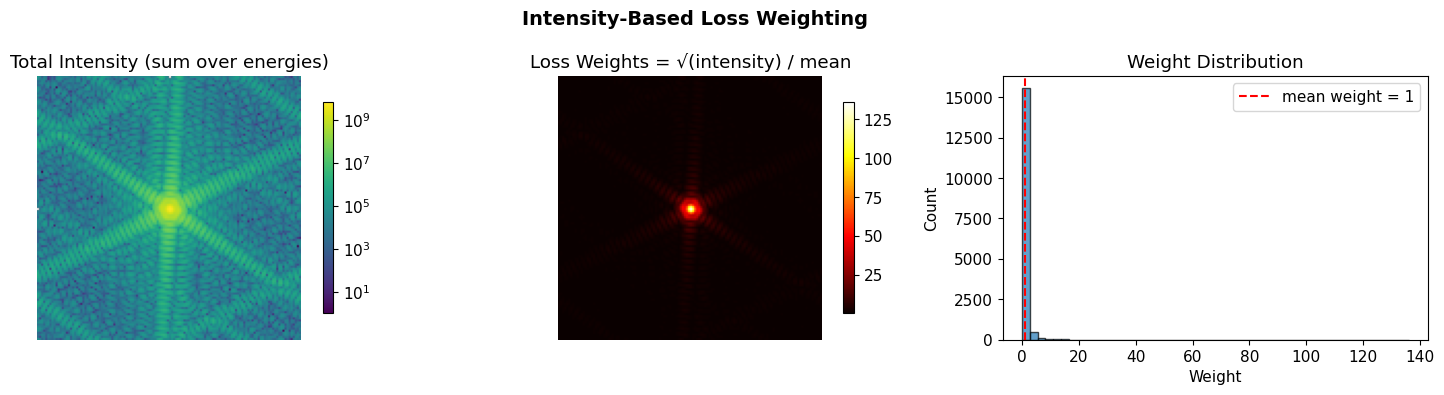

High-intensity regions (bright areas) get higher weights in the loss.
This focuses learning on pixels with reliable signal.


In [12]:
# Visualize the intensity weighting concept
total_intensity = intensity_cube.sum(axis=2)
weights = np.sqrt(total_intensity + 1e-6)
weights = weights / weights.mean()  # Normalize to mean=1

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(total_intensity, norm=LogNorm(), cmap='viridis')
axes[0].set_title('Total Intensity (sum over energies)')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(weights, cmap='hot')
axes[1].set_title('Loss Weights = √(intensity) / mean')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# Show weight distribution
axes[2].hist(weights.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(1.0, color='red', linestyle='--', label='mean weight = 1')
axes[2].set_xlabel('Weight')
axes[2].set_ylabel('Count')
axes[2].set_title('Weight Distribution')
axes[2].legend()

for ax in axes[:2]:
    ax.axis('off')

plt.suptitle('Intensity-Based Loss Weighting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("High-intensity regions (bright areas) get higher weights in the loss.")
print("This focuses learning on pixels with reliable signal.")

### Diagnostic: Intensity Distribution Across Patches

One critical issue identified in CNN training is the **dramatic intensity variation** between center and edge patches. This causes:
1. **Loss function bias**: High-intensity patches dominate the loss
2. **Uneven learning**: CNN learns center regions well, ignores edges

Let's visualize this problem:

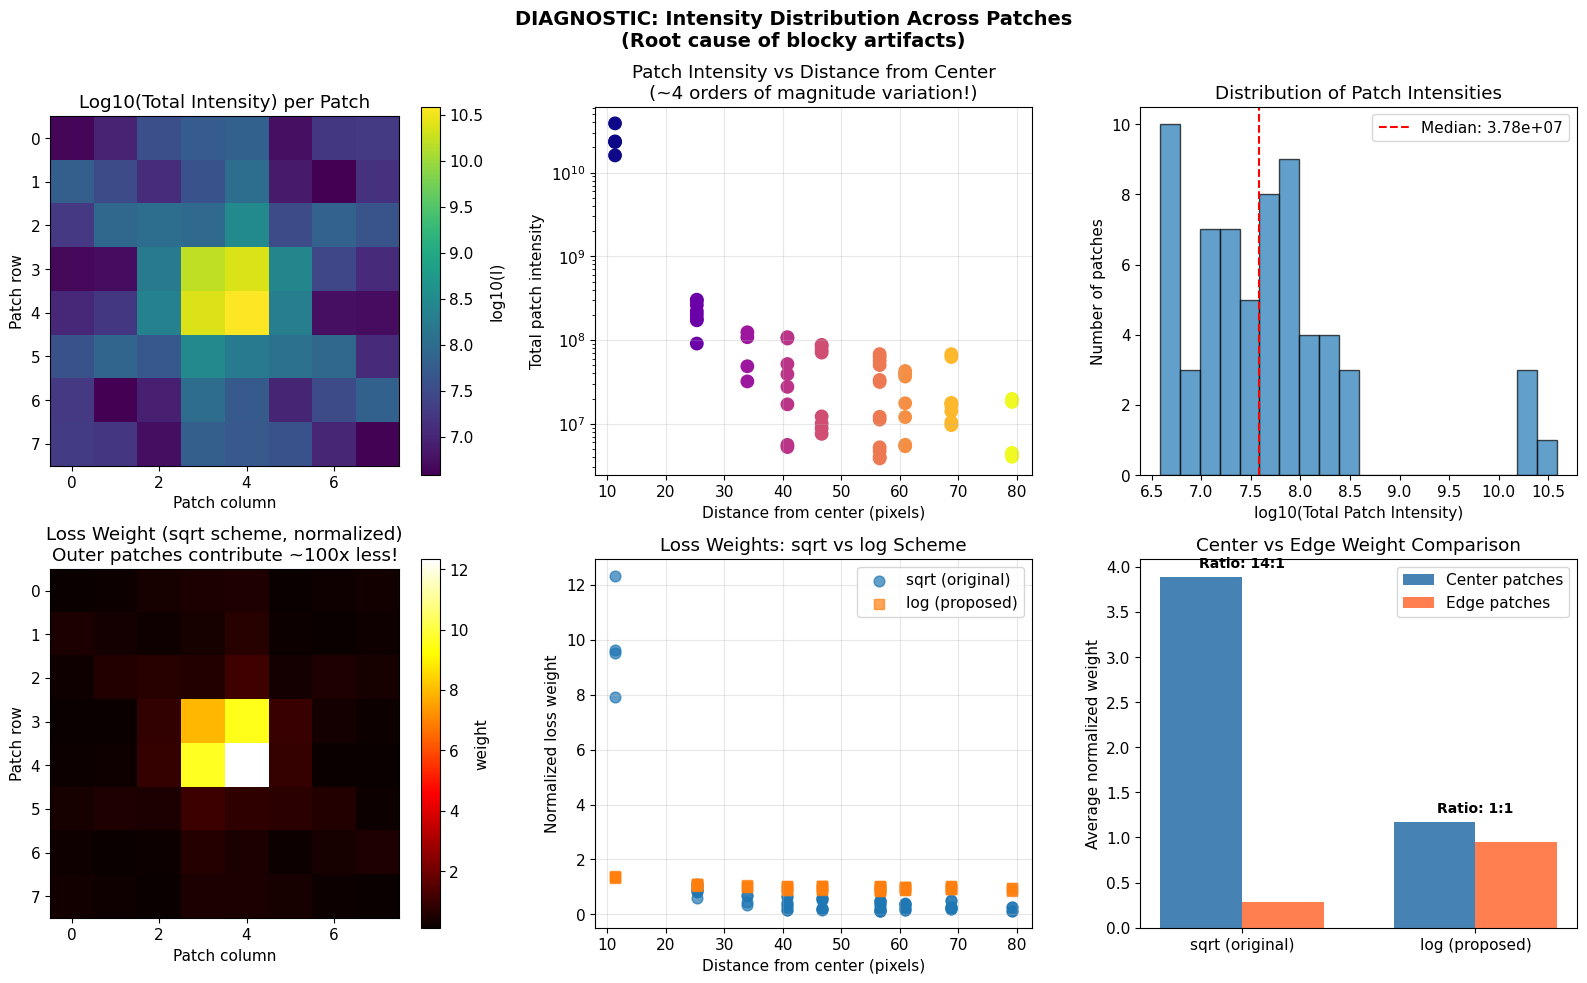


INTENSITY DISTRIBUTION DIAGNOSTIC

Patch intensity range: [3.85e+06, 3.88e+10]
Dynamic range: 10063x

Center patches (d < 30): avg intensity = 8.61e+09
Edge patches (d > 50):   avg intensity = 2.52e+07
Intensity ratio: 342:1

With sqrt weighting:
  Center/edge weight ratio: 14:1
  --> Edge patches contribute 7.4% as much to loss

With log weighting:
  Center/edge weight ratio: 1.2:1
  --> Edge patches contribute 80% as much to loss

--> Log weighting is 11x more balanced!


In [13]:
# Diagnostic: Intensity distribution across patches
# This reveals why the CNN may struggle with outer regions

PATCH_SIZE = 16
n_patches_per_row = intensity_cube.shape[0] // PATCH_SIZE  # 8 patches per row for 128px image

# Extract patches and compute statistics
patch_total_intensities = []
patch_positions = []
patch_center_distances = []

center = intensity_cube.shape[0] // 2  # 64 for 128px

for i in range(n_patches_per_row):
    for j in range(n_patches_per_row):
        y_start, x_start = i * PATCH_SIZE, j * PATCH_SIZE
        patch = intensity_cube[y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE, :]
        
        # Total intensity summed over all energies and pixels
        total_I = patch.sum()
        patch_total_intensities.append(total_I)
        
        # Patch center position
        patch_cy = y_start + PATCH_SIZE // 2
        patch_cx = x_start + PATCH_SIZE // 2
        patch_positions.append((patch_cy, patch_cx))
        
        # Distance from image center
        dist = np.sqrt((patch_cy - center)**2 + (patch_cx - center)**2)
        patch_center_distances.append(dist)

patch_total_intensities = np.array(patch_total_intensities)
patch_center_distances = np.array(patch_center_distances)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Intensity map by patch
ax = axes[0, 0]
intensity_map = patch_total_intensities.reshape(n_patches_per_row, n_patches_per_row)
im = ax.imshow(np.log10(intensity_map + 1), cmap='viridis')
ax.set_title('Log10(Total Intensity) per Patch')
ax.set_xlabel('Patch column')
ax.set_ylabel('Patch row')
plt.colorbar(im, ax=ax, label='log10(I)')

# 2. Intensity vs distance from center
ax = axes[0, 1]
ax.scatter(patch_center_distances, patch_total_intensities, s=80, c=patch_center_distances, cmap='plasma')
ax.set_xlabel('Distance from center (pixels)')
ax.set_ylabel('Total patch intensity')
ax.set_yscale('log')
ax.set_title('Patch Intensity vs Distance from Center\n(~4 orders of magnitude variation!)')
ax.grid(True, alpha=0.3)

# 3. Histogram of patch intensities
ax = axes[0, 2]
ax.hist(np.log10(patch_total_intensities + 1), bins=20, edgecolor='black', alpha=0.7)
ax.set_xlabel('log10(Total Patch Intensity)')
ax.set_ylabel('Number of patches')
ax.set_title('Distribution of Patch Intensities')
ax.axvline(np.median(np.log10(patch_total_intensities + 1)), color='red', linestyle='--', 
           label=f'Median: {np.median(patch_total_intensities):.2e}')
ax.legend()

# 4. Loss weights (sqrt scheme) by patch
ax = axes[1, 0]
sqrt_weights = np.sqrt(patch_total_intensities)
sqrt_weights_norm = sqrt_weights / sqrt_weights.mean()
weight_map = sqrt_weights_norm.reshape(n_patches_per_row, n_patches_per_row)
im = ax.imshow(weight_map, cmap='hot')
ax.set_title('Loss Weight (sqrt scheme, normalized)\nOuter patches contribute ~100x less!')
ax.set_xlabel('Patch column')
ax.set_ylabel('Patch row')
plt.colorbar(im, ax=ax, label='weight')

# 5. Compare sqrt vs log weighting schemes
ax = axes[1, 1]
log_weights = np.log1p(patch_total_intensities)
log_weights_norm = log_weights / log_weights.mean()

ax.scatter(patch_center_distances, sqrt_weights_norm, s=60, alpha=0.7, label='sqrt (original)', marker='o')
ax.scatter(patch_center_distances, log_weights_norm, s=60, alpha=0.7, label='log (proposed)', marker='s')
ax.set_xlabel('Distance from center (pixels)')
ax.set_ylabel('Normalized loss weight')
ax.set_title('Loss Weights: sqrt vs log Scheme')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Weight ratio (center vs edge)
ax = axes[1, 2]

# Define center (distance < 30) vs edge (distance > 50)
center_mask = patch_center_distances < 30
edge_mask = patch_center_distances > 50

center_sqrt_weight = sqrt_weights_norm[center_mask].mean()
edge_sqrt_weight = sqrt_weights_norm[edge_mask].mean()
center_log_weight = log_weights_norm[center_mask].mean()
edge_log_weight = log_weights_norm[edge_mask].mean()

schemes = ['sqrt (original)', 'log (proposed)']
center_weights = [center_sqrt_weight, center_log_weight]
edge_weights = [edge_sqrt_weight, edge_log_weight]
ratios = [center_sqrt_weight/edge_sqrt_weight, center_log_weight/edge_log_weight]

x = np.arange(len(schemes))
width = 0.35

bars1 = ax.bar(x - width/2, center_weights, width, label='Center patches', color='steelblue')
bars2 = ax.bar(x + width/2, edge_weights, width, label='Edge patches', color='coral')

ax.set_ylabel('Average normalized weight')
ax.set_title('Center vs Edge Weight Comparison')
ax.set_xticks(x)
ax.set_xticklabels(schemes)
ax.legend()

# Annotate ratios
for i, ratio in enumerate(ratios):
    ax.annotate(f'Ratio: {ratio:.0f}:1', (i, max(center_weights[i], edge_weights[i]) + 0.1),
                ha='center', fontsize=10, fontweight='bold')

plt.suptitle('DIAGNOSTIC: Intensity Distribution Across Patches\n(Root cause of blocky artifacts)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("INTENSITY DISTRIBUTION DIAGNOSTIC")
print("="*70)
print(f"\nPatch intensity range: [{patch_total_intensities.min():.2e}, {patch_total_intensities.max():.2e}]")
print(f"Dynamic range: {patch_total_intensities.max() / (patch_total_intensities.min() + 1e-10):.0f}x")
print(f"\nCenter patches (d < 30): avg intensity = {patch_total_intensities[center_mask].mean():.2e}")
print(f"Edge patches (d > 50):   avg intensity = {patch_total_intensities[edge_mask].mean():.2e}")
print(f"Intensity ratio: {patch_total_intensities[center_mask].mean() / patch_total_intensities[edge_mask].mean():.0f}:1")
print(f"\nWith sqrt weighting:")
print(f"  Center/edge weight ratio: {center_sqrt_weight/edge_sqrt_weight:.0f}:1")
print(f"  --> Edge patches contribute {100*edge_sqrt_weight/center_sqrt_weight:.1f}% as much to loss")
print(f"\nWith log weighting:")
print(f"  Center/edge weight ratio: {center_log_weight/edge_log_weight:.1f}:1")
print(f"  --> Edge patches contribute {100*edge_log_weight/center_log_weight:.0f}% as much to loss")
print(f"\n--> Log weighting is {(center_sqrt_weight/edge_sqrt_weight)/(center_log_weight/edge_log_weight):.0f}x more balanced!")

### Diagnostic: Input Normalization with Log Transform

Another critical issue is the **massive dynamic range** of raw intensities. The CNN sees:
- Center pixels: ~10^6 intensity
- Edge pixels: ~10^2 intensity

This 10,000x range makes it hard for the CNN to learn features across all regions. 

**Solution**: Apply `log1p(x)` transform to compress the range:

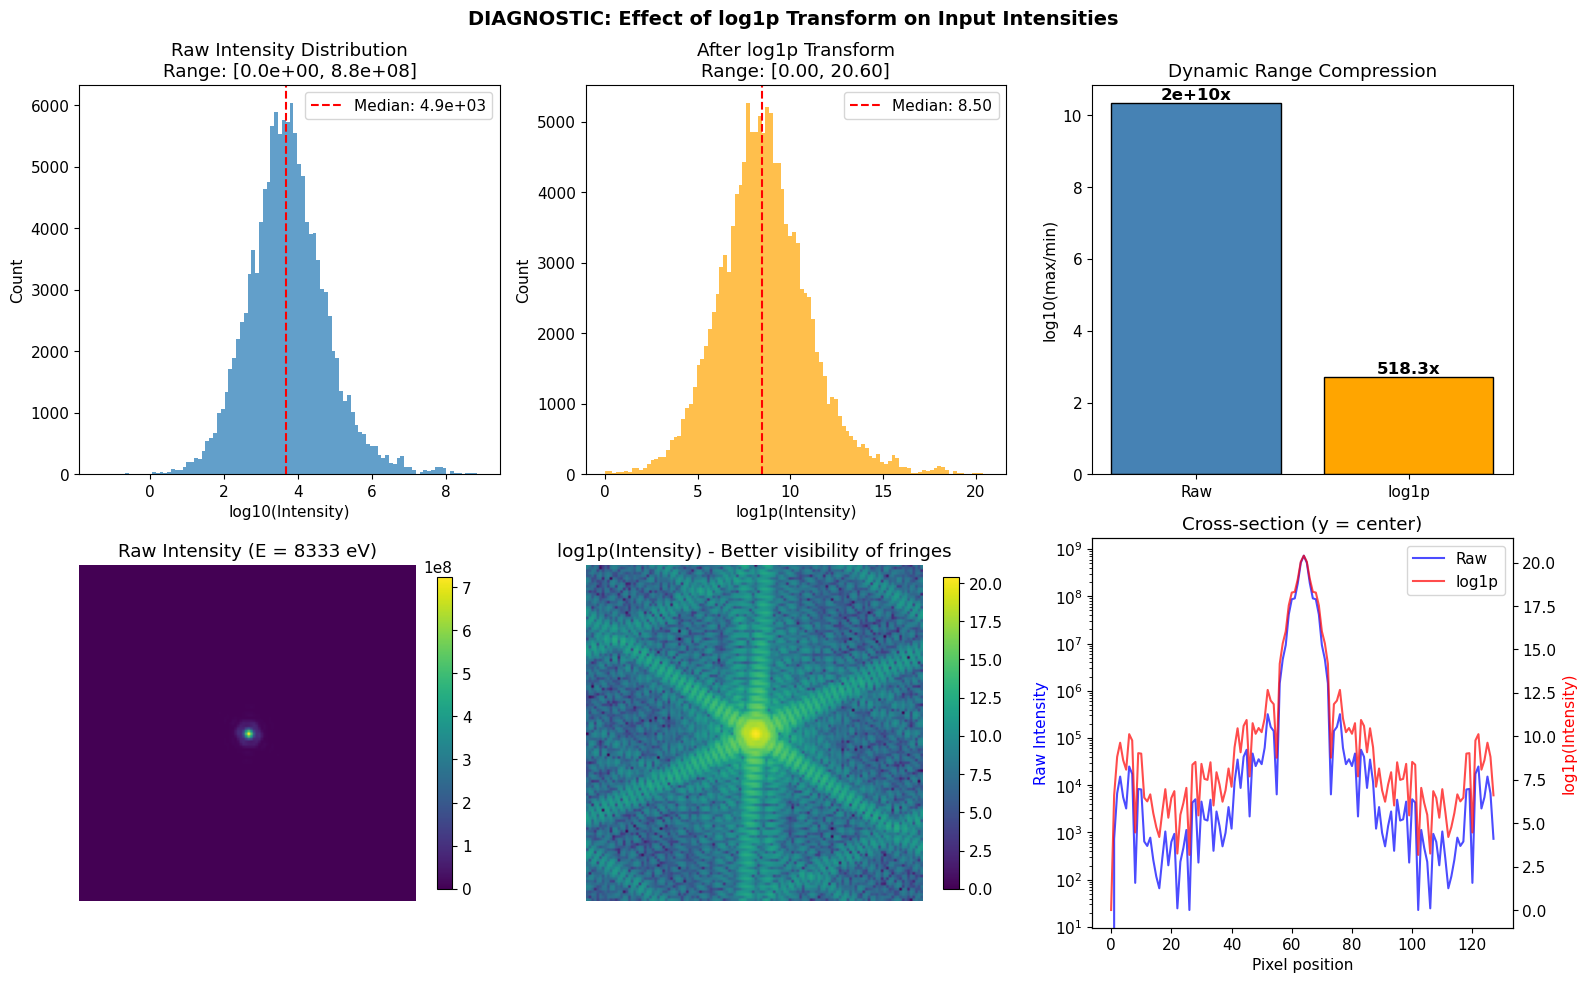


INPUT NORMALIZATION DIAGNOSTIC

Raw intensity:
  Range: [0.00e+00, 8.81e+08]
  Dynamic range: 2e+10x

After log1p transform:
  Range: [0.00, 20.60]
  Dynamic range: 518.3x

Compression factor: 41913211x

--> log1p makes the input manageable for the CNN!

RECOMMENDATION: Use --log-transform-intensity flag during training


In [14]:
# Diagnostic: Effect of log1p transform on input intensities

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Raw intensity distribution (full image)
ax = axes[0, 0]
raw_intensities = intensity_cube.flatten()
raw_nonzero = raw_intensities[raw_intensities > 0]
ax.hist(np.log10(raw_nonzero), bins=100, edgecolor='none', alpha=0.7)
ax.set_xlabel('log10(Intensity)')
ax.set_ylabel('Count')
ax.set_title(f'Raw Intensity Distribution\nRange: [{raw_intensities.min():.1e}, {raw_intensities.max():.1e}]')
median_raw = np.median(raw_nonzero)
ax.axvline(np.log10(median_raw), color='red', linestyle='--', label=f'Median: {median_raw:.1e}')
ax.legend()

# 2. Log-transformed distribution
ax = axes[0, 1]
log_intensities = np.log1p(intensity_cube).flatten()
ax.hist(log_intensities, bins=100, edgecolor='none', alpha=0.7, color='orange')
ax.set_xlabel('log1p(Intensity)')
ax.set_ylabel('Count')
ax.set_title(f'After log1p Transform\nRange: [{log_intensities.min():.2f}, {log_intensities.max():.2f}]')
ax.axvline(np.median(log_intensities), color='red', linestyle='--', label=f'Median: {np.median(log_intensities):.2f}')
ax.legend()

# 3. Compression ratio
ax = axes[0, 2]
# Show how dynamic range changes
raw_range = raw_intensities.max() / (raw_intensities[raw_intensities > 0].min())
log_range = log_intensities.max() / (log_intensities[log_intensities > 0].min() + 1e-10)

bars = ax.bar(['Raw', 'log1p'], [np.log10(raw_range), np.log10(log_range)], 
              color=['steelblue', 'orange'], edgecolor='black')
ax.set_ylabel('log10(max/min)')
ax.set_title('Dynamic Range Compression')
ax.annotate(f'{raw_range:.0e}x', (0, np.log10(raw_range) + 0.1), ha='center', fontsize=12, fontweight='bold')
ax.annotate(f'{log_range:.1f}x', (1, np.log10(log_range) + 0.1), ha='center', fontsize=12, fontweight='bold')

# 4. Visual comparison: raw vs log (middle energy)
e_idx = 4
ax = axes[1, 0]
im = ax.imshow(intensity_cube[:, :, e_idx], cmap='viridis')
ax.set_title('Raw Intensity (E = 8333 eV)')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.axis('off')

ax = axes[1, 1]
im = ax.imshow(np.log1p(intensity_cube[:, :, e_idx]), cmap='viridis')
ax.set_title('log1p(Intensity) - Better visibility of fringes')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.axis('off')

# 5. Cross-section comparison
ax = axes[1, 2]
center = intensity_cube.shape[0] // 2
raw_profile = intensity_cube[center, :, e_idx]
log_profile = np.log1p(raw_profile)

ax2 = ax.twinx()
l1, = ax.plot(raw_profile, 'b-', linewidth=1.5, alpha=0.7, label='Raw')
l2, = ax2.plot(log_profile, 'r-', linewidth=1.5, alpha=0.7, label='log1p')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Raw Intensity', color='blue')
ax2.set_ylabel('log1p(Intensity)', color='red')
ax.set_title('Cross-section (y = center)')
ax.legend([l1, l2], ['Raw', 'log1p'], loc='upper right')
ax.set_yscale('log')

plt.suptitle('DIAGNOSTIC: Effect of log1p Transform on Input Intensities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print recommendations
print("\n" + "="*70)
print("INPUT NORMALIZATION DIAGNOSTIC")
print("="*70)
print(f"\nRaw intensity:")
print(f"  Range: [{raw_intensities.min():.2e}, {raw_intensities.max():.2e}]")
print(f"  Dynamic range: {raw_range:.0e}x")
print(f"\nAfter log1p transform:")
print(f"  Range: [{log_intensities.min():.2f}, {log_intensities.max():.2f}]")
print(f"  Dynamic range: {log_range:.1f}x")
print(f"\nCompression factor: {raw_range/log_range:.0f}x")
print(f"\n--> log1p makes the input manageable for the CNN!")
print(f"\nRECOMMENDATION: Use --log-transform-intensity flag during training")

### Summary: Recommended Training Configuration

Based on the diagnostics above, to fix blocky artifacts and improve outer region predictions:

```bash
# Recommended training command
python train_cnn.py --data-dir /path/to/data \
    --weight-scheme log \
    --log-transform-intensity \
    --output-dir training_output_balanced
```

**Key flags:**
- `--weight-scheme log`: Use log weighting instead of sqrt for more balanced loss contribution
- `--log-transform-intensity`: Apply log1p to inputs to compress dynamic range

**For inference, remember to use the same flag:**
```bash
python run_inference_3d.py -c checkpoint.pt \
    --intensity data.npy --energies energies.npy \
    -o output/ \
    --log-transform-intensity  # MUST match training!
```

---

# 7. CNN Architecture

We use a **U-Net** architecture, which is well-suited for image-to-image prediction tasks.

## Architecture Overview

```
Input: (B, 8, 16, 16) intensity patches + (B, 8) f' + (B, 8) f''
       │
       ▼
┌─────────────────────────────────────────────────────────────┐
│                        ENCODER                              │
│  Conv 8→32 → Conv 32→64 → Conv 64→128                      │
│  (each with BatchNorm + ReLU + MaxPool)                    │
└─────────────────────────────────────────────────────────────┘
       │
       ▼
┌─────────────────────────────────────────────────────────────┐
│                      BOTTLENECK                             │
│  Conv 128→256                                               │
│  + f'/f'' injection via MLP (16 → 64 → 256)                │
│  The scattering factors are embedded and added here        │
└─────────────────────────────────────────────────────────────┘
       │
       ▼
┌─────────────────────────────────────────────────────────────┐
│                        DECODER                              │
│  UpConv 256→128 → UpConv 128→64 → UpConv 64→32             │
│  (each with skip connections from encoder)                  │
└─────────────────────────────────────────────────────────────┘
       │
       ▼
┌─────────────────────────────────────────────────────────────┐
│                     OUTPUT HEADS                            │
│  Magnitudes: Conv→Softplus (ensures |F_T|, |F_A| ≥ 0)      │
│  Phase:      Conv→Tanh (ensures sin, cos ∈ [-1, 1])        │
└─────────────────────────────────────────────────────────────┘
       │
       ▼
Output: (B, 4, 16, 16) → |F_T|, |F_A|, sin(Δφ), cos(Δφ)
```

## Key Design Choices

1. **f'/f'' injection at bottleneck**: The scattering factors vary with energy but are constant across pixels. We inject them at the bottleneck so the network can modulate its decoding based on the energy-dependent physics.

2. **Separate output heads**: Magnitudes need different activation (Softplus for positivity) than phase components (Tanh for bounded output).

3. **Skip connections**: Preserve spatial detail from encoder to decoder.

4. **~200K parameters**: Small enough to train quickly, large enough to capture the physics.

## Patch-Based Processing

The CNN processes 16×16 patches independently:
- Full 128×128 image → 64 non-overlapping patches
- Each patch is processed independently
- Results are stitched back together

For smooth boundaries during inference, we use **overlapping patches with Hann window blending**.

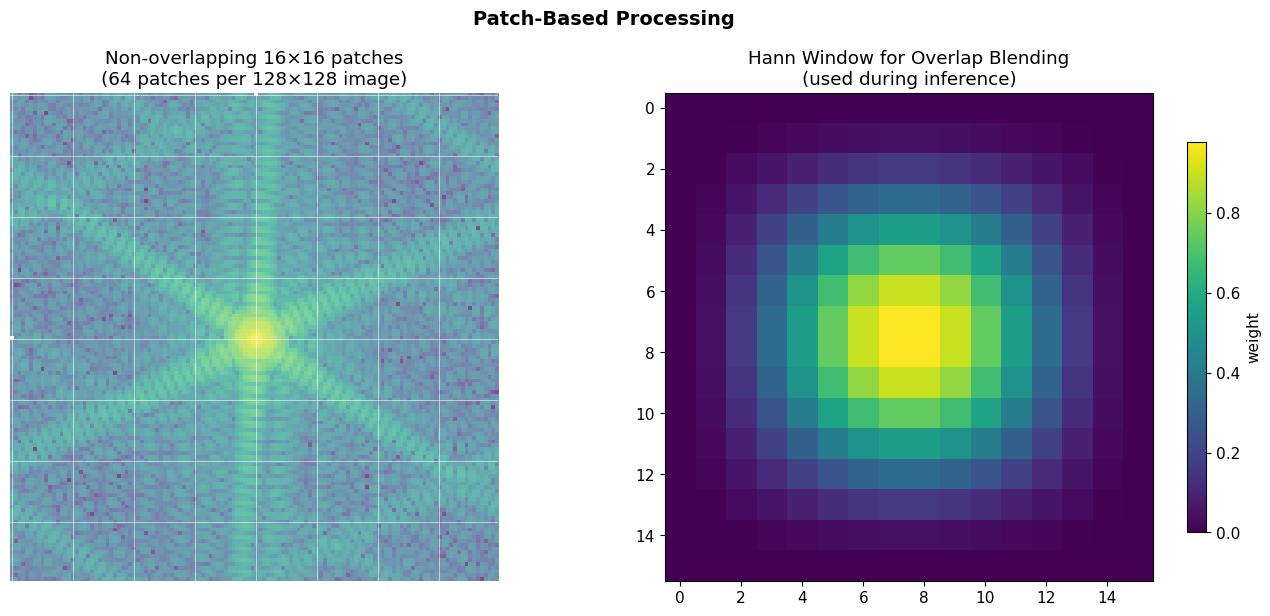

Training: Non-overlapping patches (or 50% overlap for boundary-aware training)
Inference: Overlapping patches with Hann window blending for smooth results


In [15]:
# Visualize the patching scheme
PATCH_SIZE = 16
GRID_SIZE = 128

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Show non-overlapping patches
ax = axes[0]
ax.imshow(intensity_cube[:, :, 4], norm=LogNorm(vmin=1), cmap='viridis', alpha=0.7)
for i in range(0, GRID_SIZE, PATCH_SIZE):
    ax.axhline(i, color='white', linewidth=0.5, alpha=0.8)
    ax.axvline(i, color='white', linewidth=0.5, alpha=0.8)
ax.set_title(f'Non-overlapping {PATCH_SIZE}×{PATCH_SIZE} patches\n(64 patches per 128×128 image)')
ax.axis('off')

# Show Hann window for blending
ax = axes[1]
hann_1d = np.hanning(PATCH_SIZE)
hann_2d = np.outer(hann_1d, hann_1d)
im = ax.imshow(hann_2d, cmap='viridis')
ax.set_title('Hann Window for Overlap Blending\n(used during inference)')
plt.colorbar(im, ax=ax, shrink=0.8, label='weight')

plt.suptitle('Patch-Based Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Training: Non-overlapping patches (or 50% overlap for boundary-aware training)")
print("Inference: Overlapping patches with Hann window blending for smooth results")

---

# 8. Training Pipeline

## Training Data Generation

```bash
# Generate 500 particles with overlapping patches
python generate_training_data.py -n 500 -o training_data/ --overlap --stride 8
```

This produces:
- 500 synthetic particles with varied shapes and compositions
- ~112,500 training patches (225 overlapping patches per particle)
- Each patch: 16×16×8 intensity + 16×16×4 labels

## Training Command

```bash
python train_cnn.py \
    --data-dir training_data/ \
    --output-dir training_output/ \
    --epochs 100 \
    --batch-size 64 \
    --lr 1e-3
```

## Training Dynamics

Typical training shows:
1. **Rapid initial improvement** (epochs 1-10): Loss drops quickly as network learns basic structure
2. **Steady refinement** (epochs 10-50): Gradual improvement in fine details
3. **Convergence** (epochs 50-100): Loss plateaus, validation tracks training

## Data Augmentation

We use physics-preserving augmentations:
- **Random 90° rotations**: Diffraction patterns are approximately rotationally symmetric
- **Horizontal/vertical flips**: Valid due to Friedel symmetry
- **Intensity scaling**: Simulates different exposure times

Augmentations that would break physics (e.g., independent channel shuffling) are avoided.

---

# 9. Inference & Results

## Running Inference

```bash
# 2D inference on a single particle
python run_inference.py \
    -c training_output/checkpoint_best.pt \
    -t particle_0000.npz \
    -o results/ \
    --export

# 3D inference (slice-by-slice)
python run_inference_3d.py \
    -c checkpoint.pt \
    --intensity data_3d.npy \
    --energies energies.npy \
    -o output_3d/
```

## Expected Results

A well-trained model achieves:
- **MSE Loss**: < 0.01 on validation set
- **Unit circle violation**: < 0.001 (sin² + cos² ≈ 1)
- **Reconstruction error**: < 5% relative error

## Visualization of Results

The inference scripts produce comparison plots showing:
1. Ground truth vs. predicted |F_T|, |F_A|, Δφ
2. Derived |F_N| (the Fe core contribution)
3. Intensity reconstruction error
4. Per-pixel error maps

In [16]:
# Simulate what inference results look like
# (In practice, you'd load actual predictions from a trained model)

# For demonstration, we'll add some noise to ground truth to simulate predictions
np.random.seed(123)
noise_level = 0.05

pred_F_T = labels['F_T_mag'] * (1 + noise_level * np.random.randn(*labels['F_T_mag'].shape))
pred_F_T = np.maximum(pred_F_T, 0)  # Ensure non-negative

pred_F_A = labels['F_A_mag'] * (1 + noise_level * np.random.randn(*labels['F_A_mag'].shape))
pred_F_A = np.maximum(pred_F_A, 0)

pred_sin = labels['sin_delta_phi'] + noise_level * np.random.randn(*labels['sin_delta_phi'].shape)
pred_cos = labels['cos_delta_phi'] + noise_level * np.random.randn(*labels['cos_delta_phi'].shape)

# Normalize to unit circle
norm = np.sqrt(pred_sin**2 + pred_cos**2 + 1e-10)
pred_sin_norm = pred_sin / norm
pred_cos_norm = pred_cos / norm

# Compute derived F_N
F_N_true = np.sqrt(np.maximum(
    labels['F_T_mag']**2 + labels['F_A_mag']**2 
    - 2 * labels['F_T_mag'] * labels['F_A_mag'] * labels['cos_delta_phi'], 0))

F_N_pred = np.sqrt(np.maximum(
    pred_F_T**2 + pred_F_A**2 
    - 2 * pred_F_T * pred_F_A * pred_cos_norm, 0))

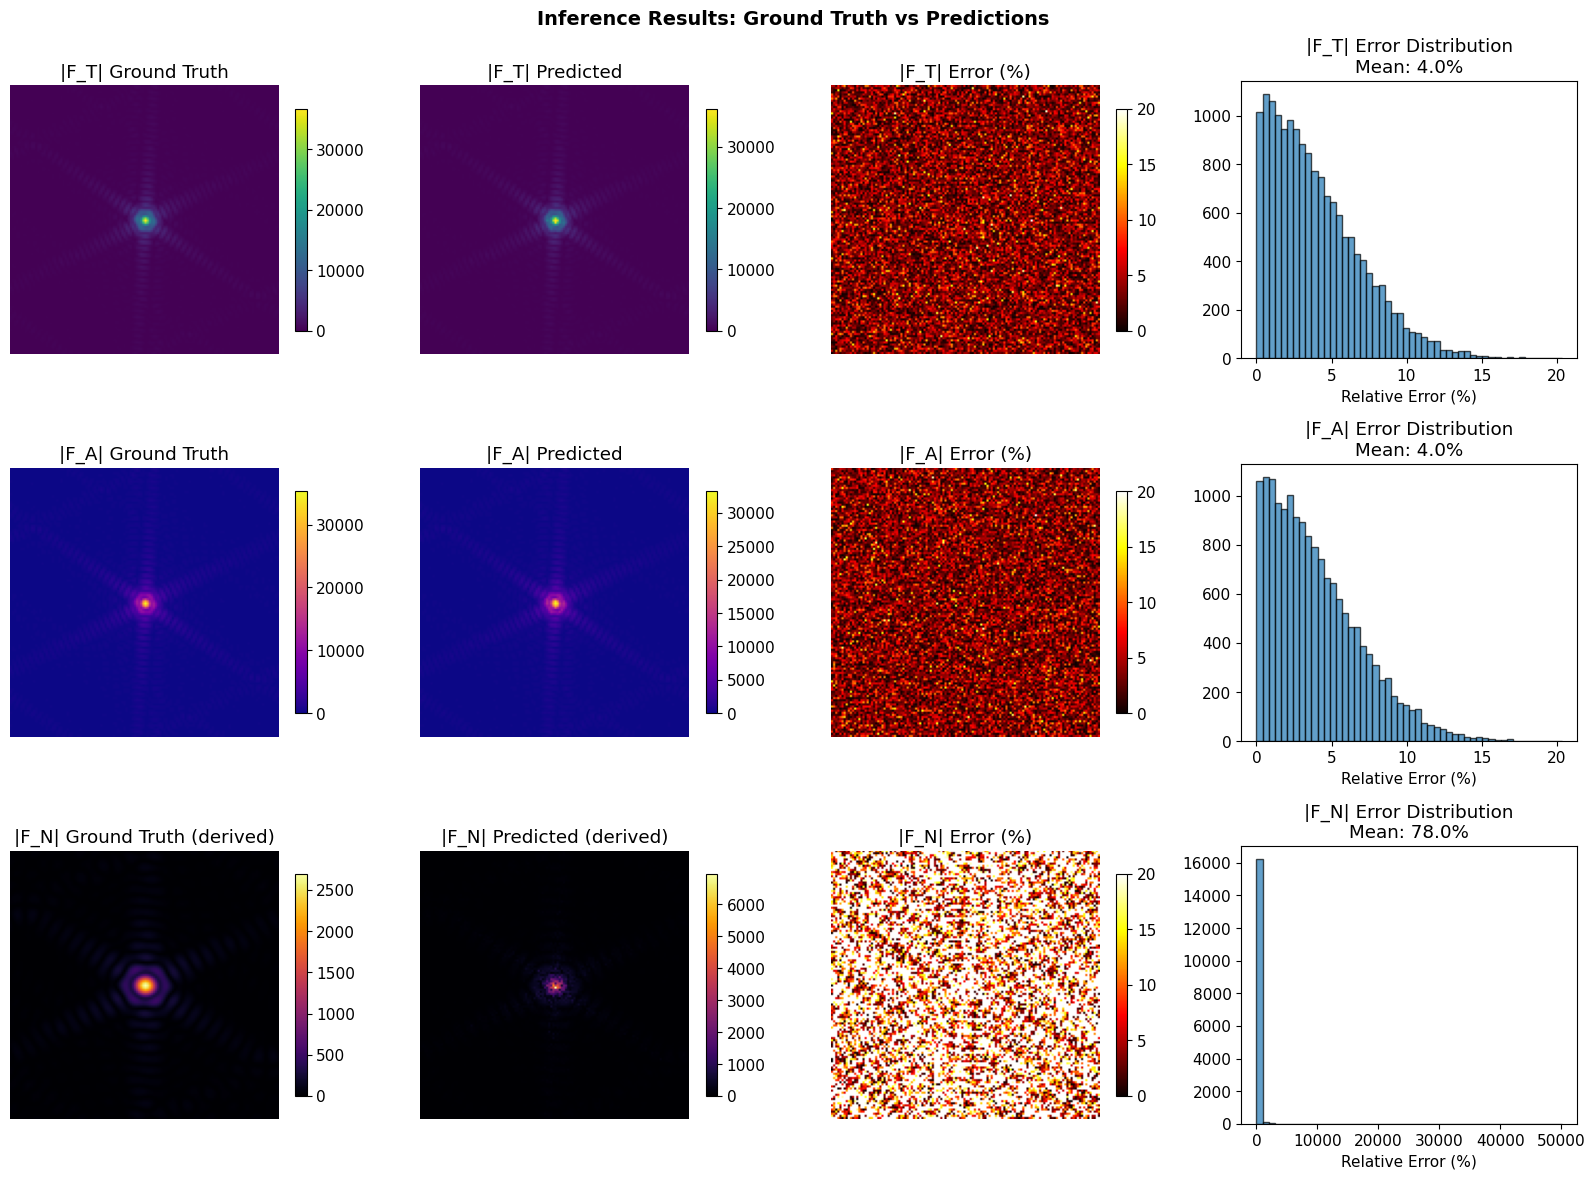

In [17]:
# Create comparison plot (Ground Truth vs Predicted)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Row 1: F_T
im = axes[0, 0].imshow(labels['F_T_mag'], cmap='viridis')
axes[0, 0].set_title('|F_T| Ground Truth')
plt.colorbar(im, ax=axes[0, 0], shrink=0.8)

im = axes[0, 1].imshow(pred_F_T, cmap='viridis')
axes[0, 1].set_title('|F_T| Predicted')
plt.colorbar(im, ax=axes[0, 1], shrink=0.8)

error_F_T = np.abs(pred_F_T - labels['F_T_mag']) / (labels['F_T_mag'] + 1e-6) * 100
im = axes[0, 2].imshow(error_F_T, cmap='hot', vmin=0, vmax=20)
axes[0, 2].set_title('|F_T| Error (%)')
plt.colorbar(im, ax=axes[0, 2], shrink=0.8)

axes[0, 3].hist(error_F_T.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 3].set_xlabel('Relative Error (%)')
axes[0, 3].set_title(f'|F_T| Error Distribution\nMean: {error_F_T.mean():.1f}%')

# Row 2: F_A
im = axes[1, 0].imshow(labels['F_A_mag'], cmap='plasma')
axes[1, 0].set_title('|F_A| Ground Truth')
plt.colorbar(im, ax=axes[1, 0], shrink=0.8)

im = axes[1, 1].imshow(pred_F_A, cmap='plasma')
axes[1, 1].set_title('|F_A| Predicted')
plt.colorbar(im, ax=axes[1, 1], shrink=0.8)

error_F_A = np.abs(pred_F_A - labels['F_A_mag']) / (labels['F_A_mag'] + 1e-6) * 100
im = axes[1, 2].imshow(error_F_A, cmap='hot', vmin=0, vmax=20)
axes[1, 2].set_title('|F_A| Error (%)')
plt.colorbar(im, ax=axes[1, 2], shrink=0.8)

axes[1, 3].hist(error_F_A.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[1, 3].set_xlabel('Relative Error (%)')
axes[1, 3].set_title(f'|F_A| Error Distribution\nMean: {error_F_A.mean():.1f}%')

# Row 3: F_N (derived)
im = axes[2, 0].imshow(F_N_true, cmap='inferno')
axes[2, 0].set_title('|F_N| Ground Truth (derived)')
plt.colorbar(im, ax=axes[2, 0], shrink=0.8)

im = axes[2, 1].imshow(F_N_pred, cmap='inferno')
axes[2, 1].set_title('|F_N| Predicted (derived)')
plt.colorbar(im, ax=axes[2, 1], shrink=0.8)

error_F_N = np.abs(F_N_pred - F_N_true) / (F_N_true + 1e-6) * 100
im = axes[2, 2].imshow(error_F_N, cmap='hot', vmin=0, vmax=20)
axes[2, 2].set_title('|F_N| Error (%)')
plt.colorbar(im, ax=axes[2, 2], shrink=0.8)

axes[2, 3].hist(error_F_N.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[2, 3].set_xlabel('Relative Error (%)')
axes[2, 3].set_title(f'|F_N| Error Distribution\nMean: {error_F_N.mean():.1f}%')

for ax in axes[:, :3].flat:
    ax.axis('off')

plt.suptitle('Inference Results: Ground Truth vs Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

# Evaluation Data: 3D Test Dataset Analysis

To evaluate the trained CNN, we use 3D test data generated from a realistic "BigParticle" simulation. This section analyzes the noise characteristics of the test data to understand if the noise level is appropriate.

## Data Generation Method

The test data was generated using the `BigParticle_V2.2_ML_Paper_Haag_NanoMAD_TRUNCATED.ipynb` notebook:

1. **Clean diffraction patterns** were computed for a 3D particle at 8 energies
2. **Poisson noise** was applied to simulate photon counting statistics:
   ```python
   POISSON_FACTOR = 1_000_000  # max counts at brightest pixel
   counts = np.random.poisson(POISSON_FACTOR * I_clean / I_max)
   ```

This means the brightest pixel gets ~1 million photon counts on average, and dimmer regions get proportionally fewer counts with Poisson fluctuations.

In [18]:
# Load the 3D test data (clean and noisy)
from pathlib import Path

# Data paths (from BigParticle notebook output)
clean_path = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD_ML/evaluation_data/test_3d_clean_v2/test_intensity_3d.npy")
noisy_path = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD_ML/evaluation_data/test_3d_noise_pf1e6_v2/test_intensity_3d_noise_pf1e6.npy")

# Load data
print("Loading 3D test data...")
try:
    intensity_clean = np.load(clean_path)
    intensity_noisy = np.load(noisy_path)
    
    print(f"\nClean data:")
    print(f"  Path: {clean_path}")
    print(f"  Shape: {intensity_clean.shape}")
    print(f"  Dtype: {intensity_clean.dtype}")
    print(f"  Range: [{intensity_clean.min():.2e}, {intensity_clean.max():.2e}]")
    print(f"  Mean: {intensity_clean.mean():.2e}")
    
    print(f"\nNoisy data (POISSON_FACTOR = 1e6):")
    print(f"  Path: {noisy_path}")
    print(f"  Shape: {intensity_noisy.shape}")
    print(f"  Dtype: {intensity_noisy.dtype}")
    print(f"  Range: [{intensity_noisy.min():.2e}, {intensity_noisy.max():.2e}]")
    print(f"  Mean: {intensity_noisy.mean():.2e}")
    
    # Correlation between clean and noisy
    corr = np.corrcoef(intensity_clean.flatten(), intensity_noisy.flatten())[0, 1]
    print(f"\nCorrelation (clean vs noisy): {corr:.4f}")
    
except FileNotFoundError as e:
    print(f"Error: Could not find data files. Please check the paths.")
    print(f"  Expected clean: {clean_path}")
    print(f"  Expected noisy: {noisy_path}")
    raise e

Loading 3D test data...

Clean data:
  Path: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD_ML/evaluation_data/test_3d_clean_v2/test_intensity_3d.npy
  Shape: (128, 128, 128, 8)
  Dtype: float32
  Range: [5.28e+03, 1.16e+17]
  Mean: 7.49e+12

Noisy data (POISSON_FACTOR = 1e6):
  Path: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD_ML/evaluation_data/test_3d_noise_pf1e6_v2/test_intensity_3d_noise_pf1e6.npy
  Shape: (128, 128, 128, 8)
  Dtype: float32
  Range: [0.00e+00, 1.00e+06]
  Mean: 7.18e+01

Correlation (clean vs noisy): 0.9959


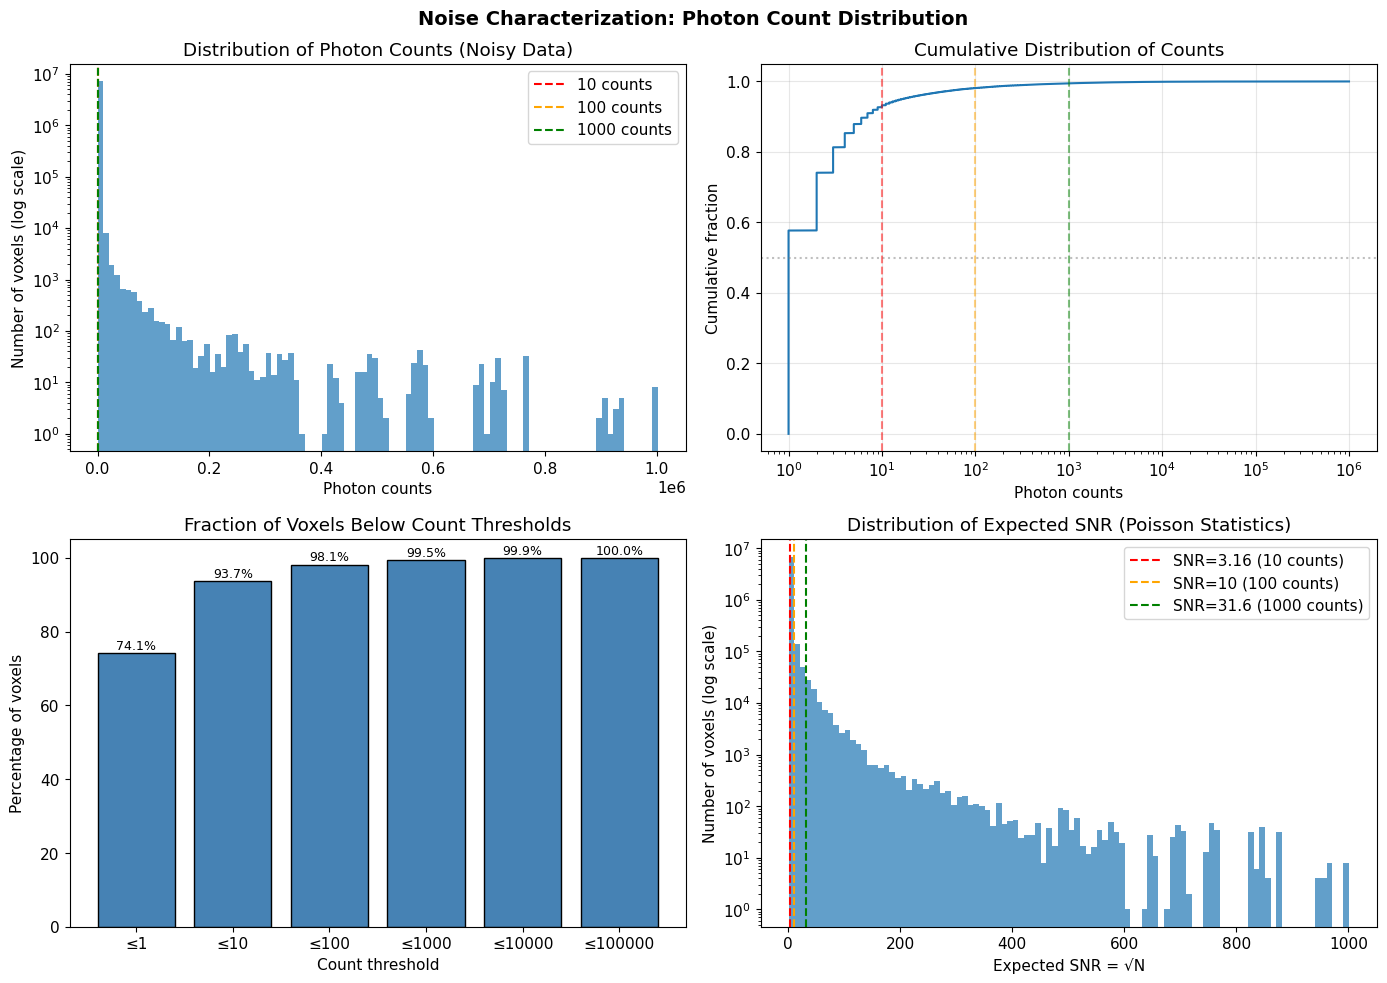


NOISE ANALYSIS SUMMARY

Total voxels: 16,777,216
Zero-count voxels: 9,680,061 (57.7%)

Voxels with counts ≤ 10:    93.7%  (SNR ≤ 3.2)
Voxels with counts ≤ 100:   98.1%  (SNR ≤ 10)
Voxels with counts ≤ 1000:  99.5%  (SNR ≤ 32)

Median count: 0 (SNR ≈ 0.0)
Mean count: 72 (SNR ≈ 8.5)


In [19]:
# Analyze photon count distribution in noisy data
# This shows what fraction of voxels have low counts (high relative noise)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of noisy counts (log scale)
ax = axes[0, 0]
counts_flat = intensity_noisy.flatten()
counts_nonzero = counts_flat[counts_flat > 0]
ax.hist(counts_nonzero, bins=100, edgecolor='none', alpha=0.7, log=True)
ax.set_xlabel('Photon counts')
ax.set_ylabel('Number of voxels (log scale)')
ax.set_title('Distribution of Photon Counts (Noisy Data)')
ax.axvline(10, color='red', linestyle='--', label='10 counts')
ax.axvline(100, color='orange', linestyle='--', label='100 counts')
ax.axvline(1000, color='green', linestyle='--', label='1000 counts')
ax.legend()

# Cumulative distribution
ax = axes[0, 1]
sorted_counts = np.sort(counts_flat)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
ax.semilogx(sorted_counts + 1, cumulative)  # +1 to handle zeros
ax.set_xlabel('Photon counts')
ax.set_ylabel('Cumulative fraction')
ax.set_title('Cumulative Distribution of Counts')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax.axvline(10, color='red', linestyle='--', alpha=0.5)
ax.axvline(100, color='orange', linestyle='--', alpha=0.5)
ax.axvline(1000, color='green', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Fraction of voxels below thresholds
ax = axes[1, 0]
thresholds = [1, 10, 100, 1000, 10000, 100000]
fractions = [np.mean(counts_flat <= t) * 100 for t in thresholds]
bars = ax.bar(range(len(thresholds)), fractions, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(thresholds)))
ax.set_xticklabels([f'≤{t}' for t in thresholds])
ax.set_xlabel('Count threshold')
ax.set_ylabel('Percentage of voxels')
ax.set_title('Fraction of Voxels Below Count Thresholds')
for bar, frac in zip(bars, fractions):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{frac:.1f}%', ha='center', fontsize=9)

# Expected SNR distribution (for Poisson: SNR = sqrt(N))
ax = axes[1, 1]
snr_expected = np.sqrt(counts_nonzero)
ax.hist(snr_expected, bins=100, edgecolor='none', alpha=0.7, log=True)
ax.set_xlabel('Expected SNR = √N')
ax.set_ylabel('Number of voxels (log scale)')
ax.set_title('Distribution of Expected SNR (Poisson Statistics)')
ax.axvline(3.16, color='red', linestyle='--', label='SNR=3.16 (10 counts)')
ax.axvline(10, color='orange', linestyle='--', label='SNR=10 (100 counts)')
ax.axvline(31.6, color='green', linestyle='--', label='SNR=31.6 (1000 counts)')
ax.legend()

plt.suptitle('Noise Characterization: Photon Count Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("NOISE ANALYSIS SUMMARY")
print("="*60)
print(f"\nTotal voxels: {len(counts_flat):,}")
print(f"Zero-count voxels: {np.sum(counts_flat == 0):,} ({100*np.mean(counts_flat == 0):.1f}%)")
print(f"\nVoxels with counts ≤ 10:    {100*np.mean(counts_flat <= 10):.1f}%  (SNR ≤ 3.2)")
print(f"Voxels with counts ≤ 100:   {100*np.mean(counts_flat <= 100):.1f}%  (SNR ≤ 10)")
print(f"Voxels with counts ≤ 1000:  {100*np.mean(counts_flat <= 1000):.1f}%  (SNR ≤ 32)")
print(f"\nMedian count: {np.median(counts_flat):.0f} (SNR ≈ {np.sqrt(np.median(counts_flat)):.1f})")
print(f"Mean count: {np.mean(counts_flat):.0f} (SNR ≈ {np.sqrt(np.mean(counts_flat)):.1f})")

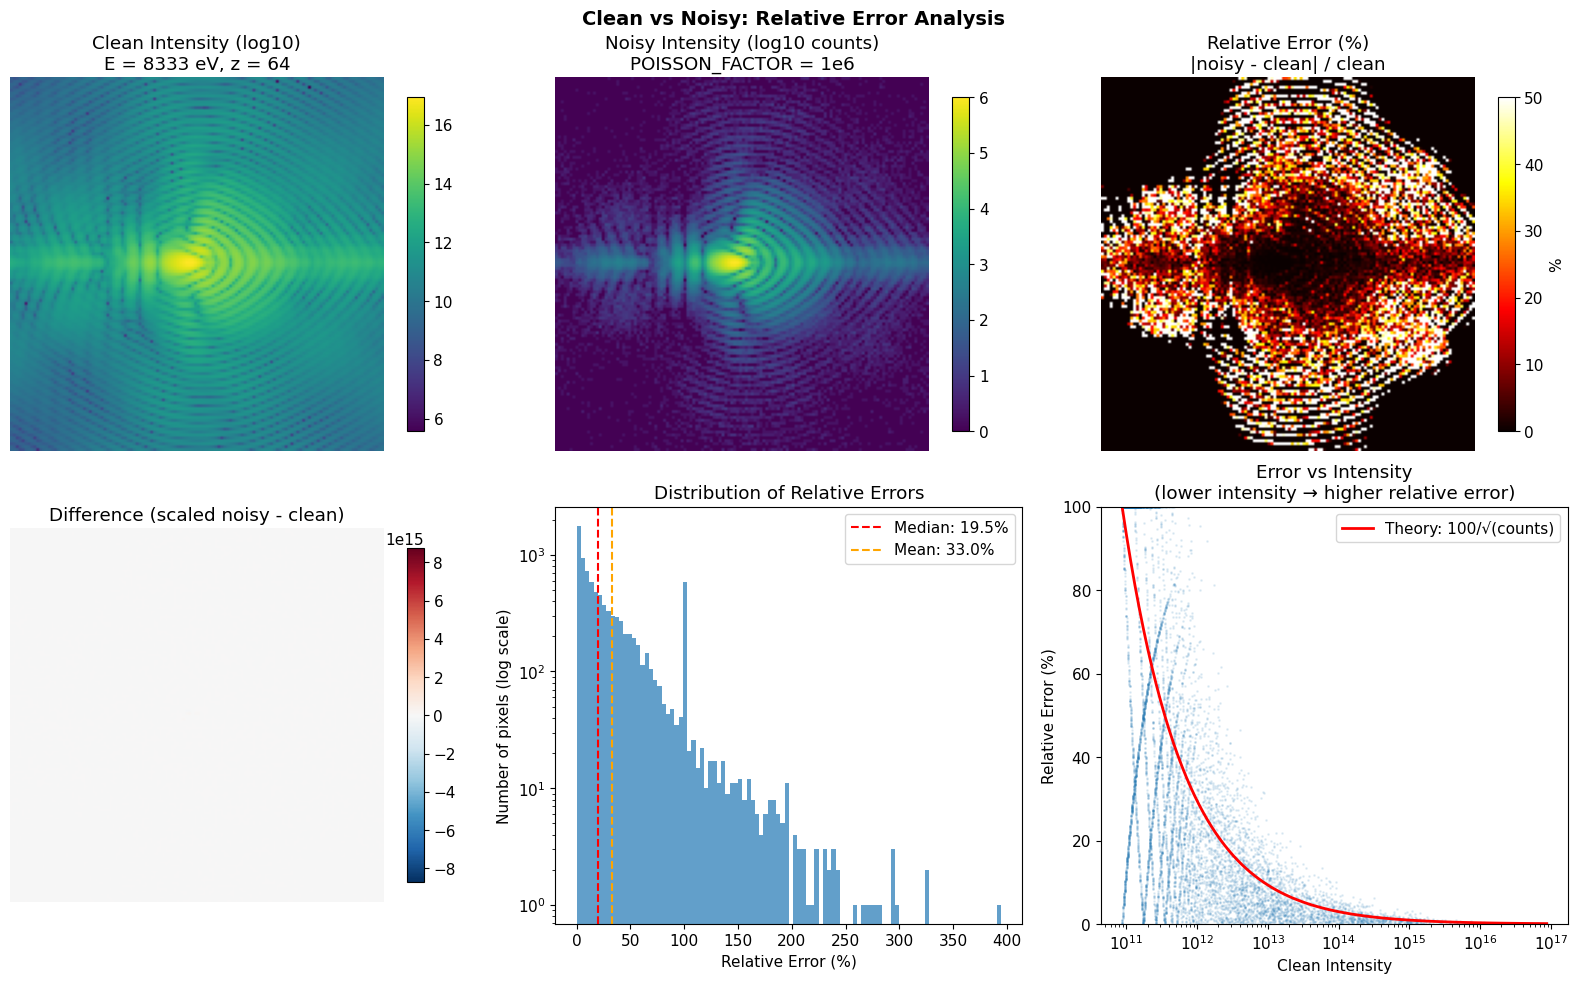


Relative Error Statistics (pixels with signal):
  Median: 19.5%
  Mean: 33.0%
  Std: 37.7%
  90th percentile: 100.0%


In [20]:
# Relative error analysis: Compare clean vs noisy
# The noisy data needs to be scaled back to compare with clean

# Scale noisy data to match clean data scale for comparison
# (The noise generation scaled by I_max, so we need to account for this)
POISSON_FACTOR = 1_000_000

# For each energy, the scaling was: counts = Poisson(PF * I_clean / I_max)
# So expected counts = PF * I_clean / I_max
# To get back to clean scale: I_scaled = counts * I_max / PF

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Compute relative error for middle energy slice
e_idx = 4  # Middle energy
z_center = intensity_clean.shape[0] // 2

clean_slice = intensity_clean[z_center, :, :, e_idx]
noisy_slice = intensity_noisy[z_center, :, :, e_idx]

# Scale noisy back to clean units for comparison
I_max_clean = clean_slice.max()
noisy_scaled = noisy_slice * I_max_clean / POISSON_FACTOR

# Relative error (only where clean > threshold to avoid div by zero)
threshold = clean_slice.max() * 1e-6  # 1e-6 of max
mask = clean_slice > threshold
relative_error = np.zeros_like(clean_slice)
relative_error[mask] = np.abs(noisy_scaled[mask] - clean_slice[mask]) / clean_slice[mask] * 100

# Plot clean slice
im0 = axes[0, 0].imshow(np.log10(clean_slice + 1), cmap='viridis', origin='lower')
axes[0, 0].set_title(f'Clean Intensity (log10)\nE = 8333 eV, z = {z_center}')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.8)

# Plot noisy slice (in counts)
im1 = axes[0, 1].imshow(np.log10(noisy_slice + 1), cmap='viridis', origin='lower')
axes[0, 1].set_title(f'Noisy Intensity (log10 counts)\nPOISSON_FACTOR = 1e6')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.8)

# Plot relative error
im2 = axes[0, 2].imshow(relative_error, cmap='hot', vmin=0, vmax=50, origin='lower')
axes[0, 2].set_title('Relative Error (%)\n|noisy - clean| / clean')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.8, label='%')

# Difference map
diff = noisy_scaled - clean_slice
im3 = axes[1, 0].imshow(diff, cmap='RdBu_r', origin='lower',
                        vmin=-0.1*clean_slice.max(), vmax=0.1*clean_slice.max())
axes[1, 0].set_title('Difference (scaled noisy - clean)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.8)

# Error distribution histogram
ax = axes[1, 1]
error_values = relative_error[mask].flatten()
ax.hist(error_values, bins=100, edgecolor='none', alpha=0.7, log=True)
ax.axvline(np.median(error_values), color='red', linestyle='--', 
           label=f'Median: {np.median(error_values):.1f}%')
ax.axvline(np.mean(error_values), color='orange', linestyle='--',
           label=f'Mean: {np.mean(error_values):.1f}%')
ax.set_xlabel('Relative Error (%)')
ax.set_ylabel('Number of pixels (log scale)')
ax.set_title('Distribution of Relative Errors')
ax.legend()

# Error vs intensity scatter (subsample for speed)
ax = axes[1, 2]
n_sample = min(10000, np.sum(mask))
idx = np.random.choice(np.sum(mask), n_sample, replace=False)
clean_values = clean_slice[mask].flatten()[idx]
error_samples = error_values[idx]
ax.scatter(clean_values, error_samples, alpha=0.1, s=1)
ax.set_xscale('log')
ax.set_xlabel('Clean Intensity')
ax.set_ylabel('Relative Error (%)')
ax.set_title('Error vs Intensity\n(lower intensity → higher relative error)')
ax.set_ylim(0, 100)

# Add theoretical Poisson curve: relative_error = 1/sqrt(N) = sqrt(I_max/(PF*I))
I_theory = np.logspace(np.log10(clean_values.min()+1), np.log10(clean_values.max()), 100)
error_theory = 100 / np.sqrt(POISSON_FACTOR * I_theory / I_max_clean)
ax.plot(I_theory, error_theory, 'r-', linewidth=2, label='Theory: 100/√(counts)')
ax.legend()

for ax in axes[0, :]:
    ax.axis('off')
axes[1, 0].axis('off')

plt.suptitle('Clean vs Noisy: Relative Error Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nRelative Error Statistics (pixels with signal):")
print(f"  Median: {np.median(error_values):.1f}%")
print(f"  Mean: {np.mean(error_values):.1f}%")
print(f"  Std: {np.std(error_values):.1f}%")
print(f"  90th percentile: {np.percentile(error_values, 90):.1f}%")

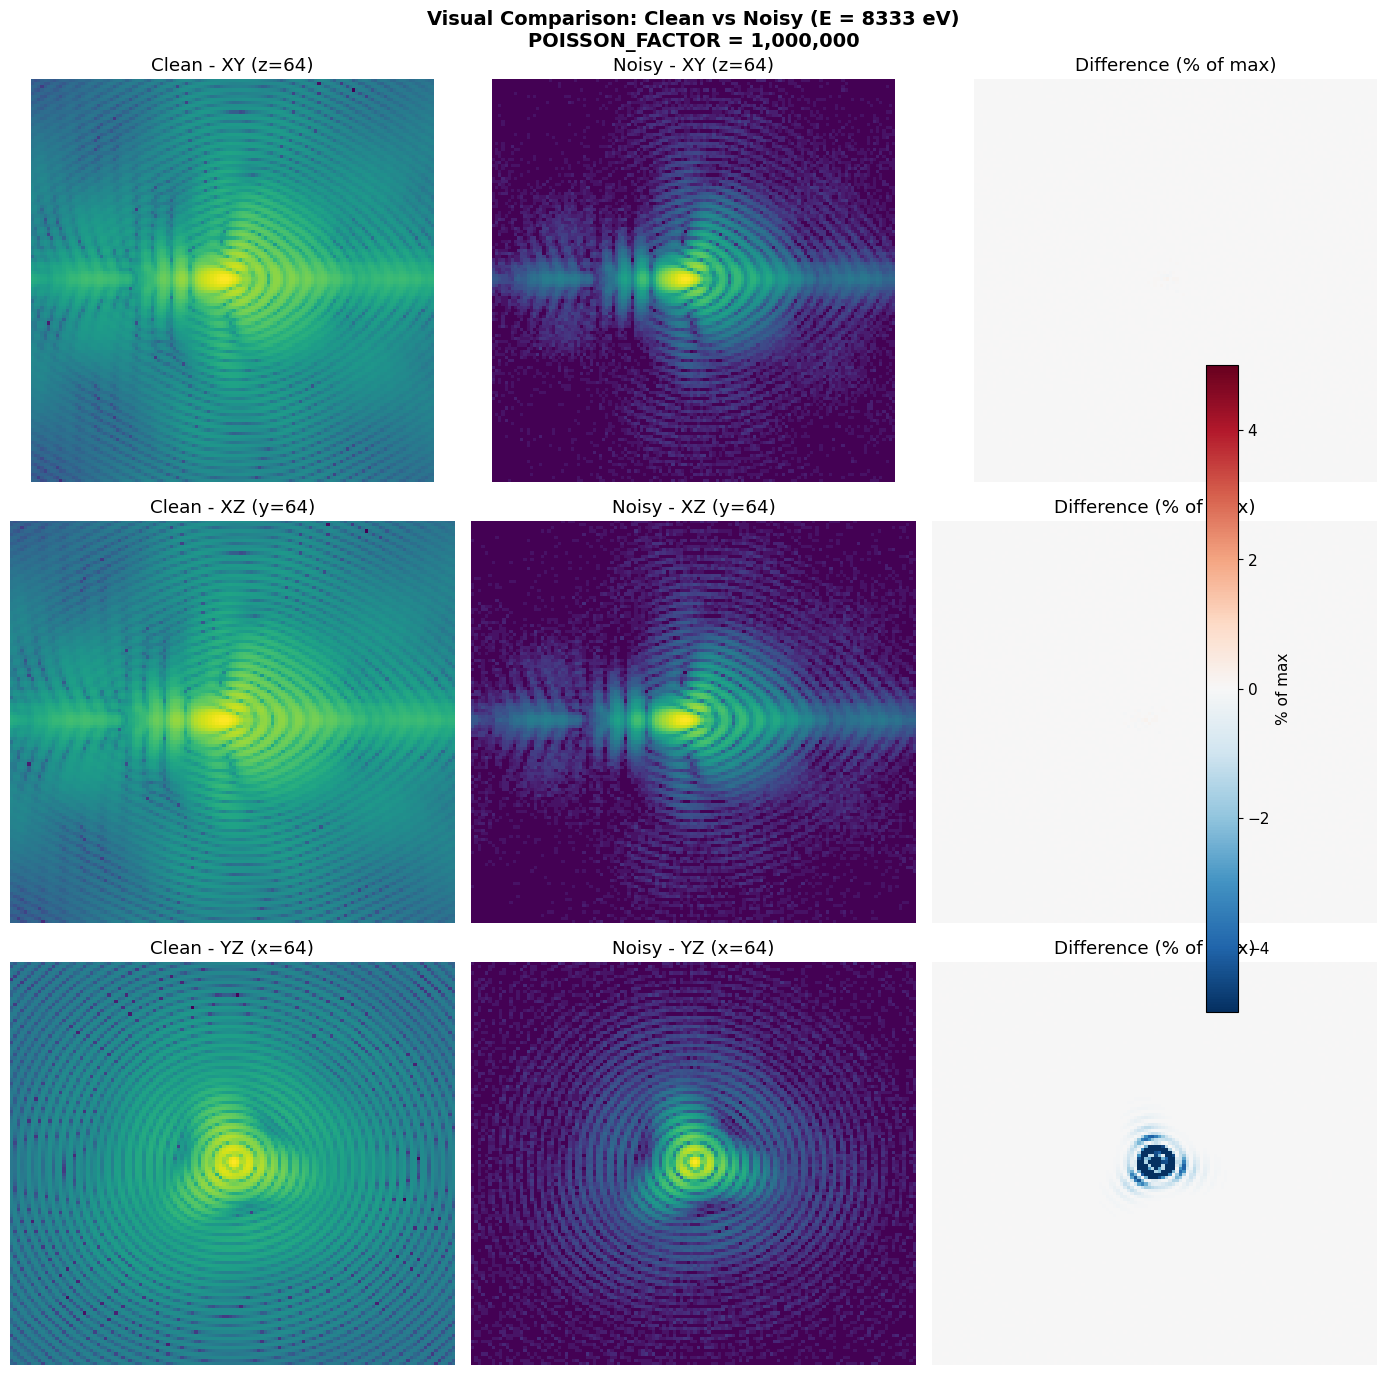


Key observations:
- The noisy data visually resembles the clean data (high correlation)
- Differences are most visible in low-intensity regions (edges, fringes)
- Central bright regions have minimal visible noise

If the noise appears too high/low, adjust POISSON_FACTOR in data generation.


In [21]:
# Visual comparison: Clean vs Noisy across orthogonal slices
# Show XY, XZ, YZ central slices for one energy

fig, axes = plt.subplots(3, 3, figsize=(14, 14))

e_idx = 4  # Middle energy (8333 eV)
z_center = intensity_clean.shape[0] // 2
y_center = intensity_clean.shape[1] // 2
x_center = intensity_clean.shape[2] // 2

# Helper for log normalization
def log_normalize(data, vmin=None, vmax=None):
    """Normalize data for display with log scale"""
    return np.log10(data + 1)

# Row 0: XY slices (z = center)
axes[0, 0].imshow(log_normalize(intensity_clean[z_center, :, :, e_idx]), 
                  cmap='viridis', origin='lower')
axes[0, 0].set_title(f'Clean - XY (z={z_center})')

axes[0, 1].imshow(log_normalize(intensity_noisy[z_center, :, :, e_idx]), 
                  cmap='viridis', origin='lower')
axes[0, 1].set_title(f'Noisy - XY (z={z_center})')

# Difference (percentage of max)
clean_xy = intensity_clean[z_center, :, :, e_idx]
noisy_xy = intensity_noisy[z_center, :, :, e_idx] * clean_xy.max() / POISSON_FACTOR
diff_xy = (noisy_xy - clean_xy) / (clean_xy.max() + 1e-10) * 100
axes[0, 2].imshow(diff_xy, cmap='RdBu_r', vmin=-5, vmax=5, origin='lower')
axes[0, 2].set_title('Difference (% of max)')

# Row 1: XZ slices (y = center) 
axes[1, 0].imshow(log_normalize(intensity_clean[:, y_center, :, e_idx]), 
                  cmap='viridis', origin='lower', aspect='auto')
axes[1, 0].set_title(f'Clean - XZ (y={y_center})')

axes[1, 1].imshow(log_normalize(intensity_noisy[:, y_center, :, e_idx]), 
                  cmap='viridis', origin='lower', aspect='auto')
axes[1, 1].set_title(f'Noisy - XZ (y={y_center})')

clean_xz = intensity_clean[:, y_center, :, e_idx]
noisy_xz = intensity_noisy[:, y_center, :, e_idx] * clean_xz.max() / POISSON_FACTOR
diff_xz = (noisy_xz - clean_xz) / (clean_xz.max() + 1e-10) * 100
im = axes[1, 2].imshow(diff_xz, cmap='RdBu_r', vmin=-5, vmax=5, origin='lower', aspect='auto')
axes[1, 2].set_title('Difference (% of max)')

# Row 2: YZ slices (x = center)
axes[2, 0].imshow(log_normalize(intensity_clean[:, :, x_center, e_idx]), 
                  cmap='viridis', origin='lower', aspect='auto')
axes[2, 0].set_title(f'Clean - YZ (x={x_center})')

axes[2, 1].imshow(log_normalize(intensity_noisy[:, :, x_center, e_idx]), 
                  cmap='viridis', origin='lower', aspect='auto')
axes[2, 1].set_title(f'Noisy - YZ (x={x_center})')

clean_yz = intensity_clean[:, :, x_center, e_idx]
noisy_yz = intensity_noisy[:, :, x_center, e_idx] * clean_yz.max() / POISSON_FACTOR
diff_yz = (noisy_yz - clean_yz) / (clean_yz.max() + 1e-10) * 100
axes[2, 2].imshow(diff_yz, cmap='RdBu_r', vmin=-5, vmax=5, origin='lower', aspect='auto')
axes[2, 2].set_title('Difference (% of max)')

for ax in axes.flat:
    ax.axis('off')

plt.colorbar(im, ax=axes[:, 2], shrink=0.6, label='% of max')
plt.suptitle(f'Visual Comparison: Clean vs Noisy (E = 8333 eV)\nPOISSON_FACTOR = {POISSON_FACTOR:,}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- The noisy data visually resembles the clean data (high correlation)")
print("- Differences are most visible in low-intensity regions (edges, fringes)")
print("- Central bright regions have minimal visible noise")
print("\nIf the noise appears too high/low, adjust POISSON_FACTOR in data generation.")

---

# 10. Summary & Future Work

## What We've Built

1. **Physics engine** (`core_shell.py`): Generates realistic synthetic particles with various shapes, compositions, and displacement fields

2. **Ground truth computation**: Computes |F_T|, |F_A|, Δφ directly from known particle structure

3. **Physics-informed loss** (`mad_loss.py`): Combines MSE, unit circle constraint, and intensity reconstruction

4. **U-Net architecture** (`mad_model.py`): CNN with f'/f'' injection for energy-aware prediction

5. **Training pipeline** (`train_cnn.py`): Data loading, augmentation, training loop with logging

6. **Inference tools** (`run_inference.py`, `run_inference_3d.py`): 2D and 3D inference with visualization

## Key Advantages Over Traditional MAD Fitting

| Aspect | Traditional NanoMAD | NanoMAD ML |
|--------|---------------------|------------|
| Speed | Hours per 3D dataset | Seconds |
| Initialization | Requires good initial guess | No initialization needed |
| Robustness | Can get stuck in local minima | Learns global patterns |
| Noise handling | Per-pixel fitting | Spatial context helps |

## Future Directions

1. **3D native processing**: Current approach processes slice-by-slice; a 3D CNN could capture z-correlations

2. **Uncertainty quantification**: Predict confidence intervals, not just point estimates

3. **Transfer to experimental data**: Train on synthetic, fine-tune on experimental

4. **Multi-edge MAD**: Extend to measurements at multiple absorption edges

---

## Files Reference

| File | Purpose |
|------|---------|
| `core_shell.py` | Physics engine - particles, diffraction, ground truth |
| `mad_model.py` | CNN architecture - U-Net with f'/f'' injection |
| `mad_loss.py` | Physics-informed loss function |
| `train_cnn.py` | Training pipeline |
| `run_inference.py` | 2D inference and visualization |
| `run_inference_3d.py` | 3D inference (slice-by-slice) |
| `generate_training_data.py` | Batch training data generation |

---

*Notebook created December 2025*